---
# Classification of Biomedical Texts with Deep Learning: LSTM, GRU, and Self-Attention
---

In this section, we will leverage Clove (300d) to generate word embeddings.

In [ ]:
!pip install biopython
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.7 MB/s eta 0:00:00


In [ ]:
from Bio import Entrez
from Bio import Medline

import random
import pickle
import time
import re
import wandb
from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import ConcatDataset
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import imageio
import numpy as np
import pandas as pd
import os
from collections import defaultdict
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
from sklearn.metrics import f1_score, confusion_matrix, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# To ensure reproducibility of the results
SEED = 200
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/diseases_dataset.csv')
data.head()

,PMID,Title,Abstract,Keywords,PublicationYear,MeSH_Terms,Cleaned_Abstract,Disease,Top_Relevant_Words,Label
0,37856028,BMI1 Transduction of Human Airway Epithelial C...,Air-liquid interface (ALI)-cultured cells are ...,"['Air-liquid interface (ALI) culture', 'Cystic...",2024,"['Humans', '*Respiratory System', '*Epithelial...",air liquid interface ali cultured cell widely ...,Cystic Fibrosis,"['basal', 'ali', 'cell', 'culture', 'different...",8
1,39300351,Latent tuberculosis infection and diagnostic p...,BACKGROUND: Tuberculosis (TB) is one of the mo...,"['Interferon-gamma release assay', 'Latent tub...",2024,"['Humans', '*Diabetes Mellitus, Type 2/complic...",background tuberculosis tb one widespread infe...,Tuberculosis,"['ltbi', 'tst', 'igra', 'agreement', 'diabetic...",0
2,39602050,From Multimorbidity to Network Medicine in Pat...,The transition from a comorbidity-based to a m...,"['Lupus erythematosus', 'Multimorbidity', 'Net...",2025,[],transition comorbidity based multimorbidity fo...,Lupus,"['rheumatic', 'network', 'medicine', 'comorbid...",7
3,38663121,Structural packing of the non-amyloid componen...,Parkinson's disease (PD) is one of many neurod...,"['Amyloids', 'Neurodegenerative diseases', 'No...",2024,"['*alpha-Synuclein/chemistry/metabolism', 'Hum...",parkinson disease pd one many neurodegenerativ...,Parkinson,"['fibril', 'nac', 'domain', 'aggregation', 'em...",6
4,39098798,The role of registries in hematological disord...,Hematopoietic cell transplantation (HCT) was d...,"['Allogeneic HCT', 'Autologous HCT', 'Hematopo...",2024,"['Humans', '*Registries', '*Hematopoietic Stem...",hematopoietic cell transplantation hct develop...,Leukemia,"['hct', 'marrow', 'bone', 'worldwide', 'collab...",4


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38652 entries, 0 to 38651
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PMID                38652 non-null  int64 
 1   Title               38652 non-null  object
 2   Abstract            38652 non-null  object
 3   Keywords            38652 non-null  object
 4   PublicationYear     38652 non-null  int64 
 5   MeSH_Terms          38652 non-null  object
 6   Cleaned_Abstract    38652 non-null  object
 7   Disease             38652 non-null  object
 8   Top_Relevant_Words  38652 non-null  object
 9   Label               38652 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 2.9+ MB


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = data["Cleaned_Abstract"].values
y = data["Label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 27056 samples
Validation set: 5798 samples
Test set: 5798 samples


In [ ]:
def tokenize(text):
    """
    Tokenizes the input text by converting it to lowercase and splitting it into words.

    Args:
        text: A string containing the text to be tokenized.

    Returns:
        A list of tokens (words) from the text.
    """
    return re.findall(r'\b\w+\b', text.lower())

In [ ]:
all_tokens = [token for text in X_train for token in tokenize(text)]
vocab = Counter(all_tokens)
filtered_vocab = {word: freq for word, freq in vocab.items() if freq >= 2}
vocab_size =  40000

sorted_filtered_vocab = dict(sorted(filtered_vocab.items(), key=lambda item: item[1], reverse=True)[:vocab_size])

word_to_index = {word: idx for idx, (word, _) in enumerate(sorted_filtered_vocab.items(), 1)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = len(word_to_index)

index_to_word = {idx: word for word, idx in word_to_index.items()}
print(word_to_index["malaria"])
print(index_to_word[1])

print(index_to_word[300])
print(word_to_index["host"])

1443
patient
relationship
351


In [ ]:
def text_to_sequence(text):
    """
    Converts the tokenized text into a sequence of indices based on a word-to-index mapping.

    Args:
        text: A string containing the text to be converted.

    Returns:
        A list of integers representing the sequence of token indices.
    """
    return [word_to_index.get(token, word_to_index["<UNK>"]) for token in tokenize(text)]

def pad_to_tensor(sequences, max_len=None):
    """
    Pads sequences to the specified maximum length, or truncates them if they exceed it.

    Args:
        sequences: A list of sequences (each sequence is a list of integers).
        max_len: The maximum length to which sequences should be padded. If None, no padding is applied.

    Returns:
        A tensor containing the padded (or truncated) sequences.
    """
    padded_sequences = [torch.tensor(seq, dtype=torch.long) for seq in sequences]
    if max_len:
        padded_sequences = [seq[:max_len] for seq in padded_sequences]
        padded_sequences = [
            torch.cat([seq, torch.zeros(max_len - len(seq), dtype=torch.long)], 0) if len(seq) < max_len else seq
            for seq in padded_sequences
        ]

    return torch.stack(padded_sequences)

class TextDataset(Dataset):
    """
    Custom Dataset for handling text data and labels.

    Args:
        X_data: Input features (e.g., tokenized text).
        y_data: Labels corresponding to the text data.
        raw_text_data: (Optional) The raw text data for reference (default is None).
    """
    def __init__(self, X_data, y_data, raw_text_data=None):
        self.X = torch.tensor(X_data, dtype=torch.long)
        self.y = torch.tensor(y_data, dtype=torch.long)
        self.raw_text_data = raw_text_data

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_tensor = self.X[idx]
        target_tensor = self.y[idx]
        raw_text = self.raw_text_data[idx] if self.raw_text_data is not None else None
        return input_tensor, target_tensor, raw_text

def load_glove_embeddings(glove_path, word_to_index, embedding_dim):
    """Loads GloVe embeddings and returns an embedding matrix."""
    embedding_matrix = np.zeros((len(word_to_index), embedding_dim), dtype='float32')
    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            if word in word_to_index:
                vector = np.asarray(values[1:], dtype='float32')
                embedding_matrix[word_to_index[word]] = vector

    return torch.tensor(embedding_matrix, dtype=torch.float)

Checking the indices of the most relevant words previously obtained in the vocab.

In [ ]:
print(word_to_index["malaria"], word_to_index["infection"], word_to_index["child"], word_to_index["disease"],word_to_index["plasmodium"])
print(word_to_index["prevalence"], word_to_index["protein"], word_to_index["year"], word_to_index["animal"],word_to_index["effect"])

1443 30 71 3 7419
194 52 23 576 35


In [ ]:
X_train_seq = [text_to_sequence(text) for text in X_train]
X_val_seq = [text_to_sequence(text) for text in X_val]
X_test_seq = [text_to_sequence(text) for text in X_test]

print(X_train_seq[0])

[79, 347, 3, 40, 127, 119, 11, 445, 2521, 351, 89, 42, 342, 763, 7415, 333, 5299, 6666, 133, 448, 52, 18, 1464, 79, 4, 499, 295, 233, 31, 6666, 1243, 38, 18, 699, 389, 2717, 119, 11, 445, 161, 4, 2639, 611, 83, 1490, 387, 694, 112, 6666, 79, 412, 1440, 913, 557, 3331, 40001, 622, 728, 128, 4687, 909, 2871, 458, 64, 607, 4412, 219, 4, 190, 19, 7153, 8005, 190, 287, 375, 876, 74, 1354, 458, 93, 4, 229, 9, 654, 132, 6666, 233, 31, 1243, 917, 2298, 213, 38, 4283, 18, 775, 43, 114, 136, 445, 9, 337, 6666, 40, 429, 80, 11, 301, 79]


In [ ]:
max_length = 400

X_train_tensor = pad_to_tensor(X_train_seq, max_len=max_length)
X_val_tensor = pad_to_tensor(X_val_seq, max_len=max_length)
X_test_tensor = pad_to_tensor(X_test_seq, max_len=max_length)

print(f"Train Tensor Shape: {X_train_tensor.shape}, Type: {X_train_tensor.dtype}")
print(f"Validation Tensor Shape: {X_val_tensor.shape}, Type: {X_val_tensor.dtype}")
print(f"Test Tensor Shape: {X_test_tensor.shape}, Type: {X_test_tensor.dtype}")

y_train_tensor = torch.tensor(y_train)
y_val_tensor = torch.tensor(y_val)
y_test_tensor = torch.tensor(y_test)

Train Tensor Shape: torch.Size([27056, 400]), Type: torch.int64
Validation Tensor Shape: torch.Size([5798, 400]), Type: torch.int64
Test Tensor Shape: torch.Size([5798, 400]), Type: torch.int64


In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = load_glove_embeddings('/content/drive/MyDrive/glove/glove.6B.300d.txt', word_to_index, EMBEDDING_DIM)

train_dataset = TextDataset(X_train_tensor, y_train, raw_text_data=X_train)
val_dataset = TextDataset(X_val_tensor, y_val, raw_text_data=X_val)
test_dataset = TextDataset(X_test_tensor, y_test, raw_text_data=X_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<ipython-input-9-811d6649565c>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X_data, dtype=torch.long)


In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

combined_dataset = ConcatDataset([train_dataset, val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Combined dataset size: {len(combined_dataset)}")

Training set size: 27056
Validation set size: 5798
Test set size: 5798
Combined dataset size: 32854


---
Model Architectures: GRU, LSTM, CNN-GRU, and CNN-LSTM


In [ ]:
NUM_CLASSES = len(torch.unique(y_train_tensor))
VOCAB_SIZE = len(word_to_index)

# ==========================  GRU Model with Word Embeddings ==========================
class GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES , num_layers=1, dropout_prob=0.5, embedding_weights=None, freeze_embeddings=False):
        super(GRU_Model, self).__init__()

        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        gru_out = self.dropout(gru_out[:, -1, :])
        out = self.fc(gru_out)
        return out

# ============ LSTM Model with Word Embeddings ============
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, embedding_weights=None, num_layers=1, dropout_prob=0.3, freeze_embeddings=True):
        super(LSTM_Model, self).__init__()
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        out = self.fc(lstm_out)
        return out

# ============ GRU-CNN Model with Word Embeddings ============
class CNN_GRU_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, num_layers=1, dropout_prob=0.5, kernel_size=3, num_filters=100, embedding_weights=None, freeze_embeddings=True):
        super(CNN_GRU_Model, self).__init__()

        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv1d = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=num_filters,
            kernel_size=kernel_size,
            padding=1
        )

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)

        self.gru = nn.GRU(
            input_size=num_filters,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_prob if num_layers > 1 else 0
        )

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        conv_input = embedded.permute(0, 2, 1)
        conv_out = self.conv1d(conv_input)
        conv_out = self.relu(conv_out)
        conv_out = self.maxpool(conv_out)
        conv_out = conv_out.permute(0, 2, 1)
        gru_out, _ = self.gru(conv_out)

        gru_out = self.dropout(gru_out[:, -1, :])
        out = self.fc(gru_out)

        return out

# ============ LSTM-CNN Model with word embeddings ============
class CNN_LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=NUM_CLASSES, num_layers=1, dropout_prob=0.5, num_filters=100, kernel_size=3, embedding_weights=None, freeze_embeddings=True):
        super(CNN_LSTM_Model, self).__init__()

        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.lstm = nn.LSTM(input_size=num_filters, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conv_out = self.relu(self.conv1(embedded))
        conv_out = self.relu(self.conv2(conv_out))
        conv_out = self.pool(conv_out)

        conv_out = conv_out.permute(0, 2, 1)
        lstm_out, _ = self.lstm(conv_out)
        lstm_out = self.dropout(lstm_out[:, -1, :])

        out = self.fc(lstm_out)
        return out

In [ ]:
clip = 5.0

def epoch_time(start_time, end_time):
    """
    Calculates the elapsed time between the start and end time.

    Args:
        start_time: The start time (in seconds).
        end_time: The end time (in seconds).

    Returns:
        elapsed_mins: The elapsed time in minutes.
        elapsed_secs: The elapsed time in seconds.
    """
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y_true):
    """
    Computes accuracy for multi-class classification.
    Args:
        y_pred: Raw logits from the model (before softmax).
        y_true: True class labels (integer class indices).
    Returns:
        Accuracy score.
    """
    y_pred = torch.argmax(y_pred, dim=1)  # Get predicted class index
    correct = (y_pred == y_true).sum().item()
    total = y_true.size(0)  # Number of samples
    return correct / total

def train_epoch(model, train_loader, optimizer, criterion, device):
    """
    Train the model for one epoch.
    """
    model.train()
    total_loss, total_accuracy = 0, 0

    for batch in train_loader:
        if len(batch) == 3:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

        optimizer.zero_grad()
        output = model(input_tensor)  # Forward pass
        loss = criterion(output, target_tensor)  # Compute loss
        loss.backward()  # Backpropagation

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        batch_accuracy = calculate_accuracy(output, target_tensor)
        total_loss += loss.item()
        total_accuracy += batch_accuracy * len(target_tensor)

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader.dataset)

    return avg_loss, avg_accuracy

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model for one epoch.
    Args:
        model: Model instance.
        val_loader: DataLoader for validation data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average validation loss, accuracy, and F1-score.
    """
    model.eval()  # Set to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in val_loader:
            if len(batch) == 3:
                input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass

            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader.dataset)

    return avg_loss, avg_accuracy, f1

def get_hidden_states(model, dataloader, device):
    """
    This function extracts the hidden states from a model (either GRU or LSTM) for each sample in the dataloader.
    The hidden states are taken from the last time step of the sequence, which are typically used for classification tasks.

    Args:
        model: A PyTorch model that contains an embedding layer and either a GRU or LSTM layer.
        dataloader: A DataLoader containing batches of input data and their corresponding targets.
        device: The device (CPU or GPU) to run the model on.

    Returns:
        hidden_states: A numpy array containing the hidden states for each sample in the dataloader.
        labels: A numpy array containing the target labels corresponding to each input sample.
    """
    model.eval()
    hidden_states, labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets, _ = batch
            inputs = inputs.to(device)

            embedded = model.embedding(inputs)

            if hasattr(model, "gru"):
                gru_out, _ = model.gru(embedded)
                hidden_state = gru_out[:, -1, :]

            elif hasattr(model, "lstm"):
                lstm_out, (hidden, _) = model.lstm(embedded)
                hidden_state = hidden[-1]

            else:
                raise ValueError("Unsupported model type. Model must contain GRU or LSTM.")

            hidden_states.append(hidden_state.cpu().numpy())
            labels.append(targets.cpu().numpy())

    hidden_states = np.concatenate(hidden_states, axis=0)
    labels = np.concatenate(labels, axis=0)

    return hidden_states, labels

def count_parameters(model):
    """
    Computes the total number of trainable parameters in a model.

    Args:
        model: A PyTorch model instance.

    Returns:
        The total number of trainable parameters in the model.
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

---
Before training.

In [ ]:
model = GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=250,
    num_layers=1,
    dropout_prob=0.4,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)

Total trainable parameters: 12416859


In [ ]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for inputs, targets, _ in train_loader:
        inputs = inputs.to(device)
        embedded = model.embedding(inputs)
        embeddings.append(embedded.mean(dim=1).cpu().numpy())
        labels.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
embeddings = np.vstack(embeddings)
labels = np.array(labels)

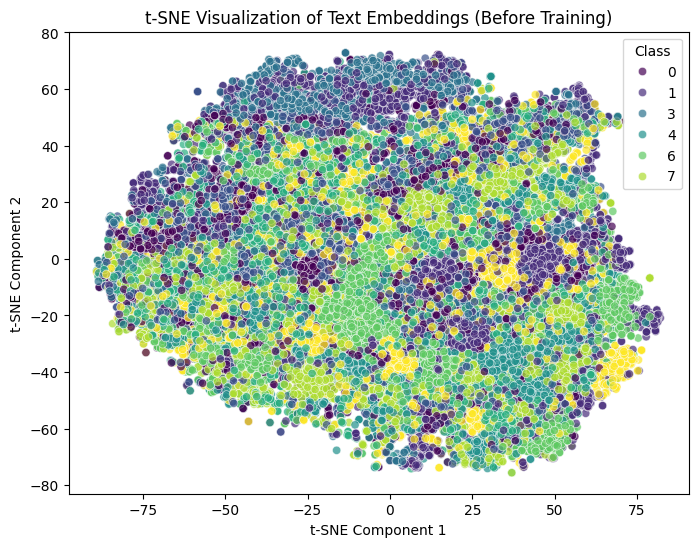

In [ ]:
# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of Text Embeddings (Before Training)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")
plt.show()

---
No clear clusters = embeddings are not yet discriminative; Overlapping colors = embeddings don’t encode label-specific information; Some local grouping.

---
#2. Validation phase
---

Training and validating model-based GRU

In [ ]:
learning_rate = 7e-4
num_epochs = 12
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 12/12 - Train Loss: 0.0957, Val Loss: 0.3150, Train Acc: 97.40%, Val Acc: 91.93%, Val F1: 91.91%, Time: 0.64 min: 100%|██████████| 12/12 [07:46<00:00, 38.86s/epoch]


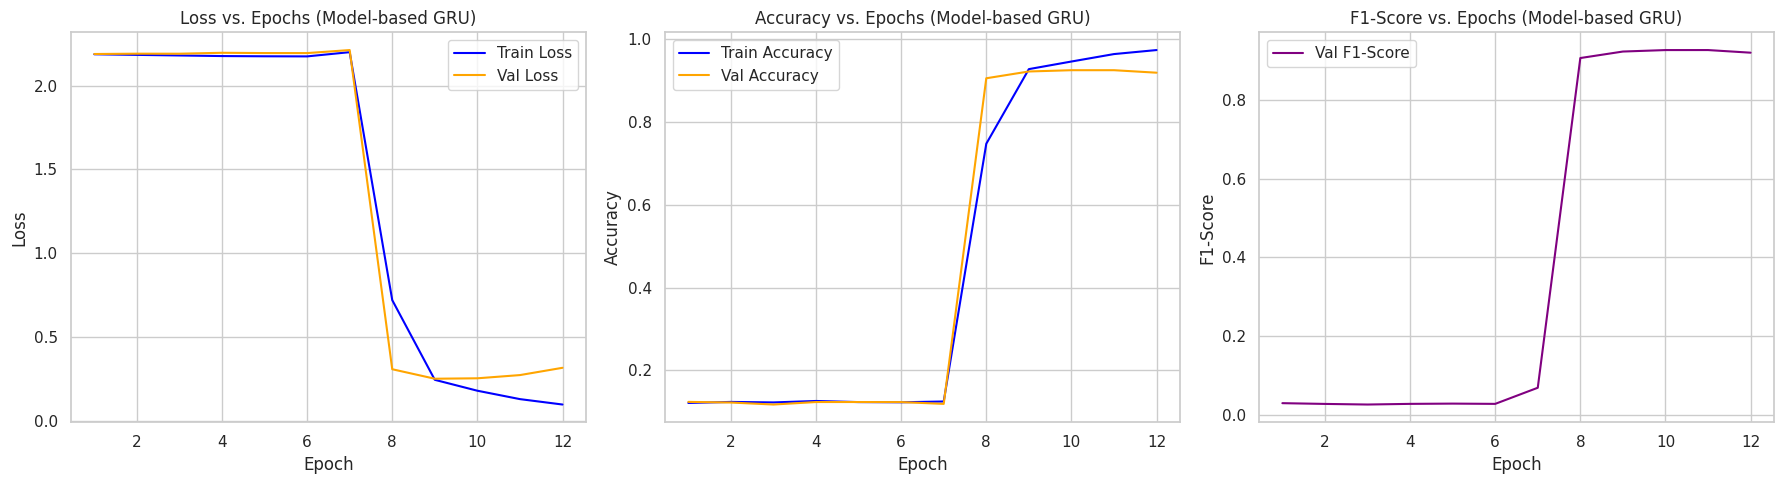

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU)')
plt.legend()

plt.tight_layout()
plt.show()

---
The model provides interesting f1-score and accurarcy value during validation phase before overfitting problem that occurs after some epochs. We will solve this overfitting problem through some techniques as early stopping, dropout and optimising the model parameters.


In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)

tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

During forward pass

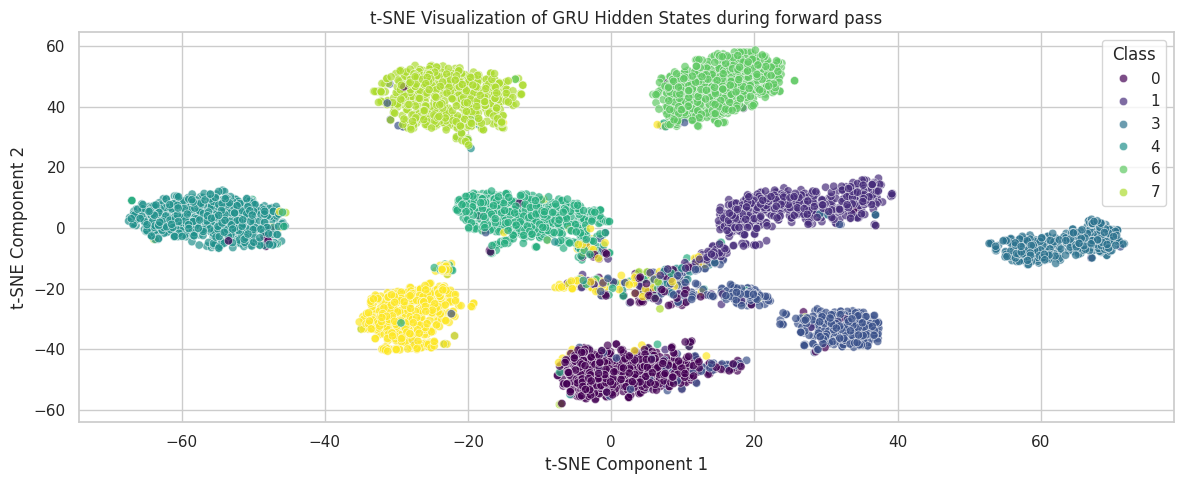

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of GRU Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.show()

---

This t-SNE visualisation indicates that GRU is succeeding in separating the different classes better than in the initial phase. Some classes are clearly distinguishable, while others remain partially mixed, suggesting that there is still room to improve the model or the pre-processing of the data.







Training and validating model-based LSTM

In [ ]:
model = LSTM_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=450,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)

Total trainable parameters: 13358259


In [ ]:
learning_rate = 1e-3
num_epochs = 25
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 25/25 - Train Loss: 0.1231, Val Loss: 0.3741, Train Acc: 96.81%, Val Acc: 90.70%, Val F1: 90.70%, Time: 1.23 min: 100%|██████████| 25/25 [30:35<00:00, 73.42s/epoch]


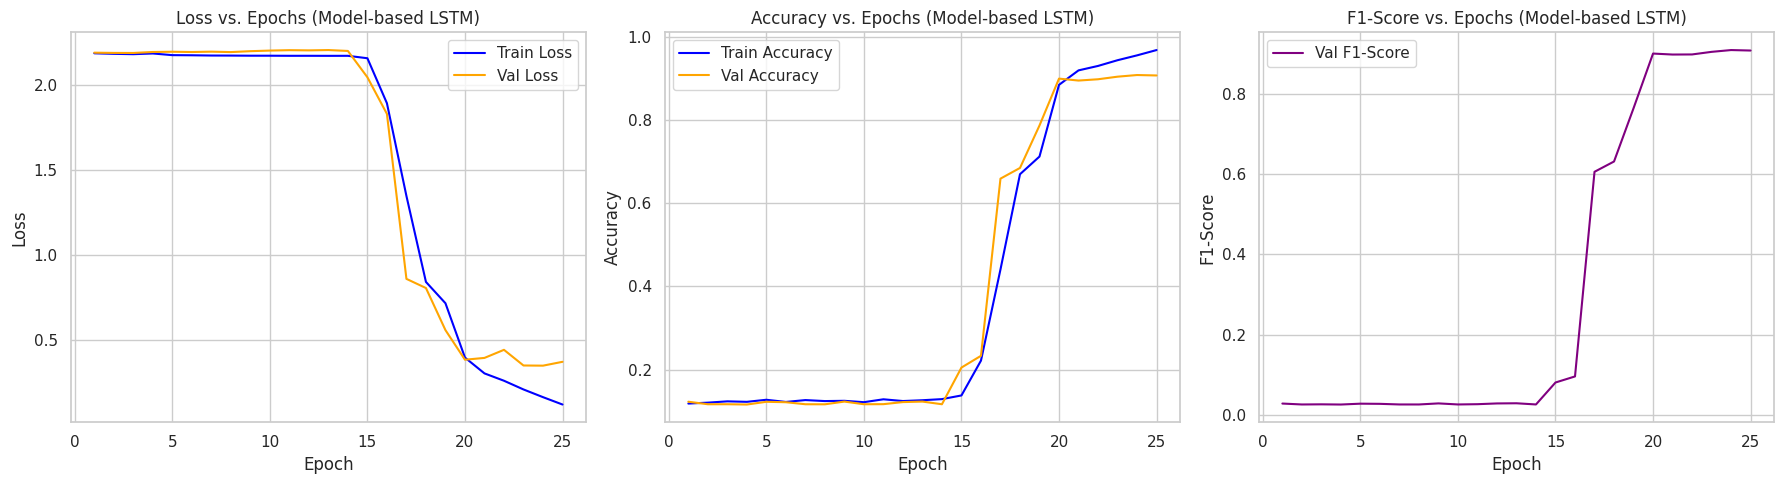

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color='blue')
sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
sns.lineplot(x=range(1, len(train_accuracies) + 1), y=train_accuracies, label='Train Accuracy', color='blue')
sns.lineplot(x=range(1, len(val_accuracies) + 1), y=val_accuracies, label='Val Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
sns.lineplot(x=range(1, len(val_f1s) + 1), y=val_f1s, label='Val F1-Score', color='purple')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

---
The model demonstrates promising F1-score and accuracy values during the validation phase before overfitting can become apparent after several epochs. To address this overfitting issue, we will implement strategies such as early stopping, dropout, and optimization of the model parameters.


In [ ]:
hidden_states, labels = get_hidden_states(model, val_loader, device)

tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_result = tsne.fit_transform(hidden_states)

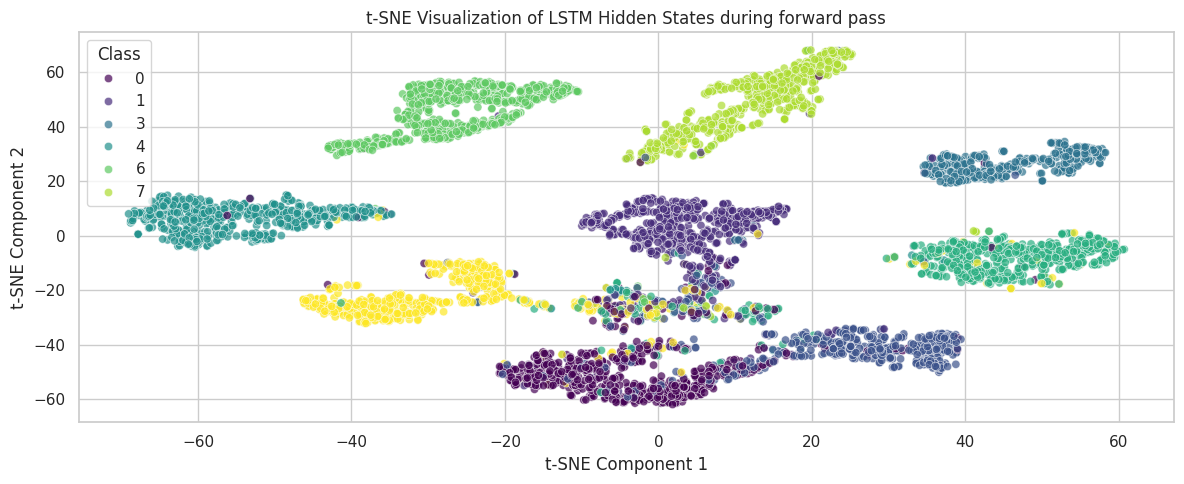

In [ ]:
plt.figure(figsize=(12, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, palette="viridis", alpha=0.7)
plt.title("t-SNE Visualization of LSTM Hidden States during forward pass")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Class")

plt.tight_layout()
plt.show()

---
This t-SNE visualisation indicates that GRU is succeeding in separating the different classes better than in the initial phase. Some classes are clearly distinguishable, while others remain partially mixed, suggesting that there is still room to improve the model or the pre-processing of the data.


Training and validating model-based GRU-CNN

In [ ]:
model = CNN_GRU_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=400,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_GRU_Model(
  (embedding): Embedding(40002, 300)
  (conv1d): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 250, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)

Total trainable parameters: 12356959


In [ ]:
learning_rate = 7*1e-4
num_epochs = 30
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 30/30 - Train Loss: 0.0628, Val Loss: 0.5142, Train Acc: 98.42%, Val Acc: 90.31%, Val F1: 90.28%, Time: 0.42 min: 100%|██████████| 30/30 [12:43<00:00, 25.45s/epoch]


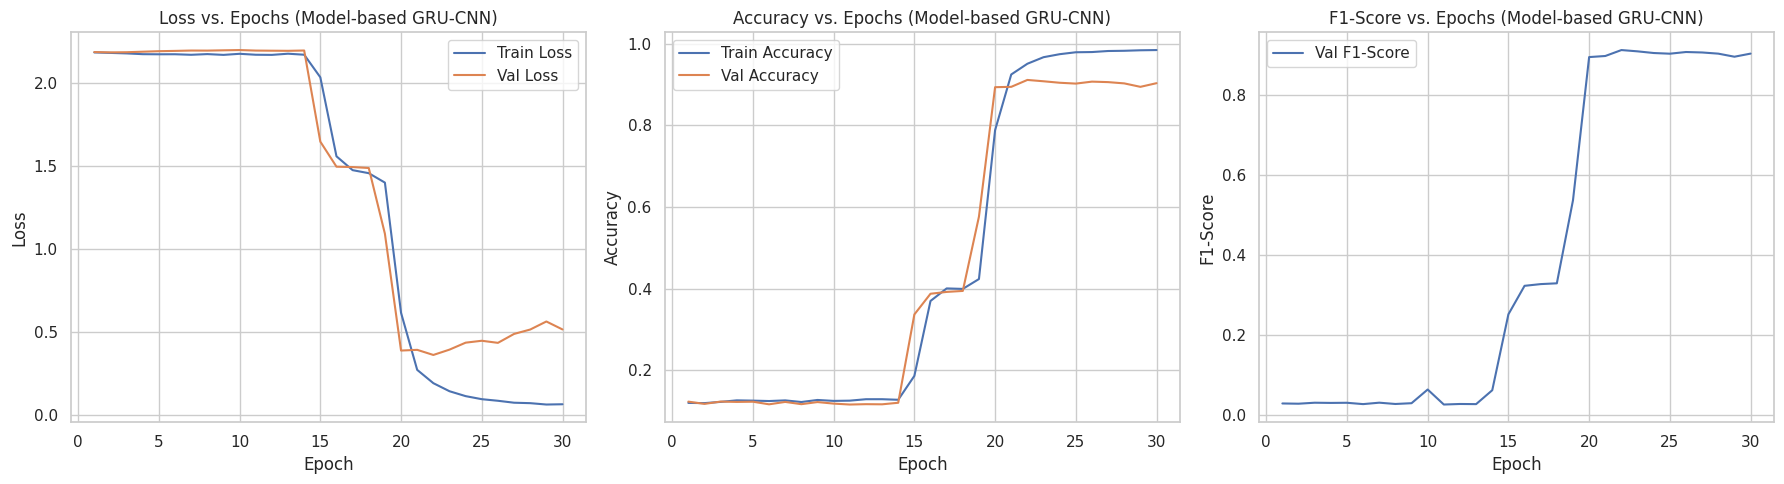

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based GRU-CNN)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based GRU-CNN)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Val F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based GRU-CNN)')
plt.legend()

plt.tight_layout()
plt.show()

---
The model initially achieves strong F1-score and accuracy metrics during validation; however, signs of overfitting can emerge after multiple epochs. To mitigate this, we will employ techniques like early stopping, dropout, and parameter optimization.


Training and validating model-based LSTM-CNN

In [ ]:
model = CNN_LSTM_Model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=450,
    num_layers=1,
    dropout_prob=0.3,
    embedding_weights=embedding_matrix,
    freeze_embeddings=False
).to(device)

print(model)
num_params = count_parameters(model)
print()
print(f"Total trainable parameters: {num_params}")

CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)

Total trainable parameters: 13118459


In [ ]:
learning_rate = 1e-3
num_epochs = 25
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

with tqdm(total=num_epochs, desc="Training Progress", unit="epoch") as pbar:
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        end_time = time.time()
        epoch_duration = end_time - start_time

        pbar.set_description(
            f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F1: {val_f1:.2%}, Time: {epoch_duration / 60:.2f} min"
        )
        pbar.update(1)

Epoch 25/25 - Train Loss: 0.0613, Val Loss: 0.4001, Train Acc: 98.14%, Val Acc: 90.44%, Val F1: 90.43%, Time: 0.75 min: 100%|██████████| 25/25 [18:40<00:00, 44.81s/epoch]


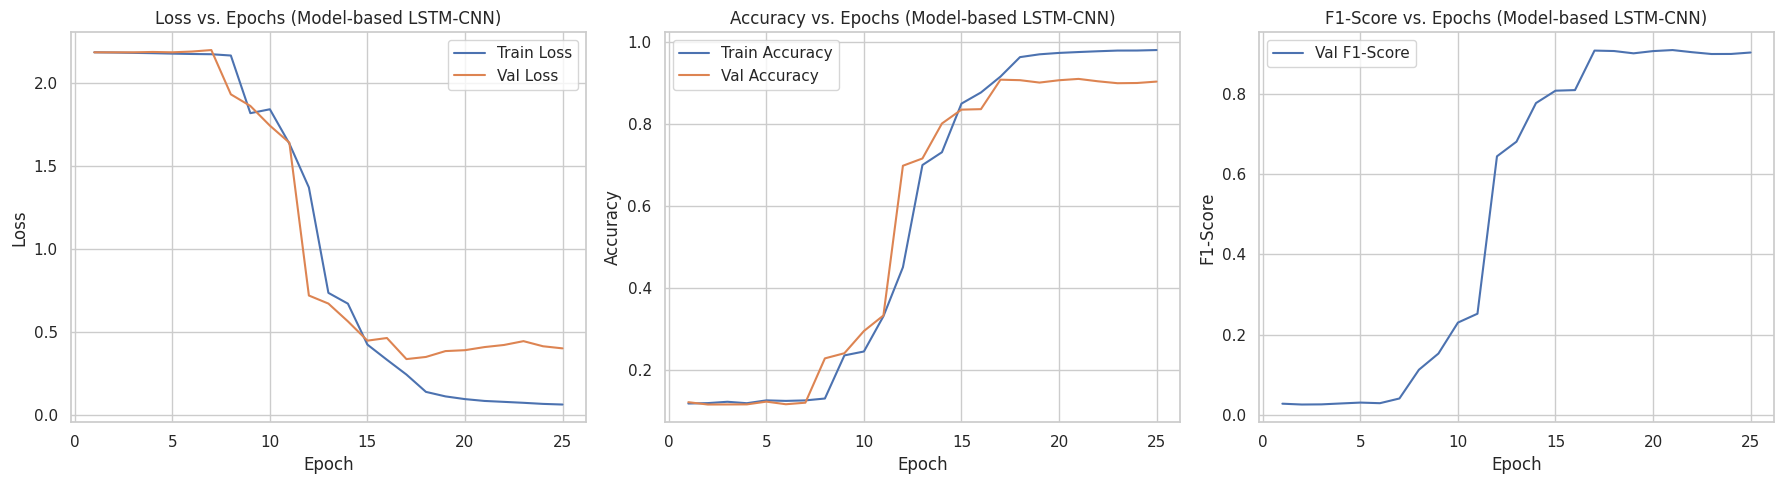

In [ ]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs (Model-based LSTM-CNN)')
plt.legend()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs (Model-based LSTM-CNN)')
plt.legend()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Val F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('F1-Score vs. Epochs (Model-based LSTM-CNN)')
plt.legend()

plt.tight_layout()
plt.show()

---
During validation, the model exhibits high F1-score and accuracy, but overfitting can become evident after several epochs. To counteract this, we will apply strategies such as early stopping, dropout, and model parameter optimization.

---
#3.Optimisation phase
---

The choice of hyperparameters for the different models was based on an analysis of the results obtained from the reports generated by Weights & Biases (WandB). These reports were used to identify the best-performing configurations in terms of accuracy, F1-score and training stability.

###3.1 Model-based GRU

3.1. a. Optimizer selection

In [ ]:
num_epochs = 12
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    wandb.init(project='Multi_Class_Optimizer_Comparison_gru_glove300d', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=9, bias=True)
)
Total trainable parameters: 12688359


Optimizer: RMSprop | Epoch 12/12 - Train Loss: 0.0524, Val Loss: 0.4042, Train ACC: 98.40%, Val ACC: 91.57%, Time: 0.76 min: 100%|██████████| 12/12 [09:17<00:00, 46.48s/epoch]


train_acc,▁▁▂▇████████
train_loss,██▇▂▁▁▁▁▁▁▁▁
val_acc,▁▁██████████
val_f1,▁▁██████████
val_loss,██▁▁▁▁▁▁▁▂▂▂
train_acc,0.98396
train_loss,0.05239
val_acc,0.91566
val_f1,0.91575
val_loss,0.40416



🔹 Training with optimizer: Adam


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=9, bias=True)
)
Total trainable parameters: 12688359


Optimizer: Adam | Epoch 12/12 - Train Loss: 0.0562, Val Loss: 0.4274, Train ACC: 98.36%, Val ACC: 90.76%, Time: 0.79 min: 100%|██████████| 12/12 [09:30<00:00, 47.51s/epoch]


train_acc,▁▁▁▇▇███████
train_loss,███▂▂▁▁▁▁▁▁▁
val_acc,▁▁▅█████████
val_f1,▁▁▆█████████
val_loss,██▄▁▁▁▁▁▁▂▁▁
train_acc,0.98363
train_loss,0.05623
val_acc,0.90755
val_f1,0.90799
val_loss,0.42743



🔹 Training with optimizer: AdamW


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 350, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=350, out_features=9, bias=True)
)
Total trainable parameters: 12688359


Optimizer: AdamW | Epoch 12/12 - Train Loss: 0.0498, Val Loss: 0.4124, Train ACC: 98.56%, Val ACC: 91.62%, Time: 0.80 min: 100%|██████████| 12/12 [09:38<00:00, 48.17s/epoch]


train_acc,▁▁▁▆████████
train_loss,███▃▂▁▁▁▁▁▁▁
val_acc,▁▁▄█████████
val_f1,▁▁▄█████████
val_loss,██▅▁▁▁▁▁▁▁▂▂
train_acc,0.98559
train_loss,0.04976
val_acc,0.91618
val_f1,0.91586
val_loss,0.41243


---
Adam optimizer is selected.


3.1.b Learning rate value selection

In [ ]:
learning_rates = [5*1e-4, 7*1e-4, 3*1e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=350, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    wandb.init(project='Multi_Class_learning_rate_tuning_gru_glove300d', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMPprop',
        'model': 'GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 350,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.0005


LR: 0.0005 | Epoch 12/12 - Train Loss: 2.1778, Val Loss: 2.2006, Train ACSA: 12.78%, Val ACSA: 11.69%, Time: 0.79 min: 100%|██████████| 12/12 [09:25<00:00, 47.15s/epoch]


train_acc,▁▅▅▆▄▆▆█▅▇▅█
train_loss,█▆▄▂▂▆▁▁▂▁▁▃
val_acc,▃▂█▇▁▃▇▇▃▃▃▃
val_f1,▁▁▂▁▂▁▂▁▁▁▁█
val_loss,▂▁▁▂▄▃▃▄▄▄▅█
train_acc,0.12785
train_loss,2.17784
val_acc,0.11694
val_f1,0.06259
val_loss,2.20058



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 12/12 - Train Loss: 0.0457, Val Loss: 0.4049, Train ACSA: 98.47%, Val ACSA: 91.55%, Time: 0.80 min: 100%|██████████| 12/12 [09:29<00:00, 47.45s/epoch]


train_acc,▁▁▁▃▇███████
train_loss,███▇▂▁▁▁▁▁▁▁
val_acc,▁▁▁█████████
val_f1,▁▁▁█████████
val_loss,███▁▁▁▁▁▁▂▂▂
train_acc,0.9847
train_loss,0.04574
val_acc,0.91549
val_f1,0.91549
val_loss,0.40486



🔹 Training with RMSprop and learning rate: 0.00030000000000000003


LR: 0.00030000000000000003 | Epoch 12/12 - Train Loss: 2.1738, Val Loss: 2.1921, Train ACSA: 12.40%, Val ACSA: 11.69%, Time: 0.79 min: 100%|██████████| 12/12 [09:28<00:00, 47.34s/epoch]


train_acc,▁▄▅▅█▄▇▃▃▄█▄
train_loss,▃▂▂▁▁▁▁█▂▁▁▁
val_acc,█▃▇▁▂▁▇▄▂▂▆▂
val_f1,▂▁▂▁▁▁▂█▁▁▆▁
val_loss,▁▃▁▂▂▃▃█▂▂▃▃
train_acc,0.12397
train_loss,2.17384
val_acc,0.11694
val_f1,0.02658
val_loss,2.19214


---
Learning rate value is set to $7 \cdot 10^{-4}$.


3.1.c Embedding value selection

In [ ]:
hidden_dims = [100, 250, 400]
num_epochs = 15

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"GRU_Hidden_{hidden_dim}"

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=hidden_dim, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    wandb.init(
        project="Multi_Class_GRU-Hidden-Tuning-glove300d",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 350,
            "dropout": 0.4,
            "optimizer": "RMSprop"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 15/15 - Train Loss: 2.1736, Val Loss: 2.1920, Train Acc: 12.76%, Val Acc: 12.33%, Val F-1: 2.89%,, Time: 0.21 min: 100%|██████████| 15/15 [03:07<00:00, 12.48s/epoch]


train_acc,▁▁▅▆▃▅▅▂▄▅█▆▇▅█
train_loss,▆▅▄▃▂▂▇█▂▂▂▁▁▂▁
val_acc,▃▃▇▂██▇▃▇▂▂█▁▂█
val_f1,▄▃▅▂▆▇▆▄▇▃▃█▁▃▇
val_loss,▃▁▁▂▅▅▅▄▄▄█▅▇█▅
train_acc,0.12759
train_loss,2.17356
val_acc,0.12332
val_f1,0.02894
val_loss,2.19196



🔹 Training with hidden_dim: 250



Epoch 15/15 - Train Loss: 0.0579, Val Loss: 0.3921, Train Acc: 98.38%, Val Acc: 91.13%, Val F-1: 91.12%,, Time: 0.65 min: 100%|██████████| 15/15 [09:41<00:00, 38.79s/epoch]


train_acc,▁▁▁▁▁▁▁▆███████
train_loss,███████▃▂▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁████████
val_f1,▁▁▁▁▁▁▁████████
val_loss,███████▁▁▁▁▁▁▂▁
train_acc,0.98377
train_loss,0.05788
val_acc,0.91135
val_f1,0.9112
val_loss,0.39213



🔹 Training with hidden_dim: 400



Epoch 15/15 - Train Loss: 0.0416, Val Loss: 0.5131, Train Acc: 98.73%, Val Acc: 90.95%, Val F-1: 90.91%,, Time: 0.91 min: 100%|██████████| 15/15 [13:35<00:00, 54.38s/epoch]


train_acc,▁▇▇████████████
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁█▅▇▄▆▆▄▄▄▃▃▁▃▂
val_f1,▁█▅▇▅▆▆▄▄▄▃▃▁▂▂
val_loss,▃▁▂▂▃▄▄▅▅▅▇▇█▇█
train_acc,0.98729
train_loss,0.04157
val_acc,0.90945
val_f1,0.90913
val_loss,0.51313


---
The larger hidden dimension value, the better is in term of F-1 score and accuracy values during validation phase. But overfitting occurs after some epochs. Thus we set the embedding dimension value to 250.


3.1.d Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")
    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-GRU-Depth-Tuning-glove300d",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":350,
            "dropout":0.4,
            "optimizer": "RMSprop"
        }
    )
    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 15/15 - Train Loss: 0.0690, Val Loss: 0.3575, Train Acc: 98.17%, Val Acc: 91.45%, Val F-1: 91.49%,, Time: 0.65 min: 100%|██████████| 15/15 [09:47<00:00, 39.16s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▇█████
train_loss,████████▆▂▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▆██████
val_f1,▁▁▁▁▁▁▁▁▅██████
val_loss,████████▃▁▁▁▁▁▁
train_acc,0.9817
train_loss,0.06899
val_acc,0.91445
val_f1,0.91493
val_loss,0.35752



🔹 Training with GRU Depth (num_layers): 2



Epoch 15/15 - Train Loss: 0.0620, Val Loss: 0.4562, Train Acc: 98.29%, Val Acc: 91.07%, Val F-1: 91.10%,, Time: 0.65 min: 100%|██████████| 15/15 [09:42<00:00, 38.80s/epoch]


train_acc,▁▁▁▁▁▁▁▇███████
train_loss,███████▂▂▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▅████████
val_f1,▁▁▁▁▁▁▅████████
val_loss,██████▅▁▁▁▁▁▁▁▂
train_acc,0.98289
train_loss,0.06202
val_acc,0.91066
val_f1,0.911
val_loss,0.45615



🔹 Training with GRU Depth (num_layers): 3



Epoch 15/15 - Train Loss: 2.1755, Val Loss: 2.1981, Train Acc: 12.60%, Val Acc: 11.66%, Val F-1: 2.56%,, Time: 0.64 min: 100%|██████████| 15/15 [09:41<00:00, 38.78s/epoch]


train_acc,▆▃▃▁▆▂█▇▅▁▅▆▆▇▆
train_loss,█▆▄▂▂▃▂█▅▂▂▂▂▁▂
val_acc,▆▇▆▁▂▁▂█▆▅▆▆▆▆▂
val_f1,▂▂▂▁▁▁▁█▂▁▁▁▂▂▁
val_loss,▁▁▂▂▂▂▂█▂▂▂▃▃▃▃
train_acc,0.12603
train_loss,2.17545
val_acc,0.11659
val_f1,0.02559
val_loss,2.19811


---
Depth value set to 1 can enable to avoid overfitting better than the both other values and also provides good performances.

3.1.e Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1,dropout_prob=0.4, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    wandb.init(
        project="Multi-Class-batch_size_comparison_gru_glove300d",
        name=f"GRU_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "RMSprop",
            "hidden_dim": 250,
            "dropout_prob": 0.4
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12416859


Epoch 15/15 - Train Loss: 0.0499, Val Loss: 0.5223, Train Acc: 98.57%, Val Acc: 90.26%, Val F-1: 90.20%,, Time: 1.11 min: 100%|██████████| 15/15 [17:08<00:00, 68.55s/epoch]


train_acc,▁▁▁▆███████████
train_loss,███▃▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁████████████
val_f1,▁▁▁████████████
val_loss,███▁▁▁▁▁▂▂▁▂▂▂▂
train_acc,0.98573
train_loss,0.0499
val_acc,0.90255
val_f1,0.90199
val_loss,0.52231



🔹 Training with batch size: 16


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12416859


Epoch 15/15 - Train Loss: 0.0388, Val Loss: 0.4180, Train Acc: 98.72%, Val Acc: 91.24%, Val F-1: 91.17%,, Time: 0.70 min: 100%|██████████| 15/15 [11:16<00:00, 45.11s/epoch]


train_acc,▁▁▁▄███████████
train_loss,███▅▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁████████████
val_f1,▁▁▁████████████
val_loss,███▁▁▁▁▁▁▁▁▂▂▂▂
train_acc,0.98725
train_loss,0.03884
val_acc,0.91238
val_f1,0.91166
val_loss,0.41802



🔹 Training with batch size: 64


GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12416859


Epoch 15/15 - Train Loss: 2.4814, Val Loss: 2.4206, Train Acc: 11.13%, Val Acc: 10.33%, Val F-1: 6.64%,, Time: 0.30 min: 100%|██████████| 15/15 [04:35<00:00, 18.35s/epoch]


train_acc,▃▄▄▄▄▄▄▄▄▅█▂▁▂▂
train_loss,▁▁▁▁▁▁▁▁▁▁▄████
val_acc,▃▂▃▂▃▃▂▂▂█▂▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁█▅▄▅▄▄
val_loss,▃▃▃▃▃▃▃▃▃▁█████
train_acc,0.11132
train_loss,2.4814
val_acc,0.10331
val_f1,0.06643
val_loss,2.42064


---

Batch size values 8 and 16 are more promising. We assign the bathc size value to 16.


###3.2 Model-based LSTM

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

3.2.a Optimizer selection

In [ ]:
num_epochs = 25
learning_rate = 1e-3
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': (optim.RMSprop, {'lr': learning_rate, 'momentum': 0.9}),
    'AdamW': (optim.AdamW, {'lr': learning_rate, 'weight_decay': 1e-5}),
    'Adam': (optim.Adam, {'lr': learning_rate})
}

for optimizer_name, (optimizer_class, optimizer_params) in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)
    optimizer = optimizer_class(model.parameters(), **optimizer_params)

    wandb.init(project='Multi_Class_Optimizer_Comparison_lstm_glove300d', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'LSTM_Model',
        'embedding_dim': 300,
        'hidden_dim': 450,
        'dropout_prob': 0.3
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)

            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_postfix({
                'Train Loss': f"{train_loss:.4f}",
                'Val Loss': f"{val_loss:.4f}",
                'Train ACC': f"{train_acc:.2%}",
                'Val ACC': f"{val_acc:.2%}",
                'Time (min)': f"{epoch_duration / 60:.2f}"
            })
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13358259


Optimizer: RMSprop: 100%|██████████| 25/25 [30:11<00:00, 72.46s/epoch, Train Loss=2.5260, Val Loss=2.3797, Train ACC=11.85%, Val ACC=7.14%, Time (min)=1.20]


train_acc,▄▇▄▄▄▃▅▂▃▇▄▅▄▄▁▅▂▄█▄▇▅▃▇▇
train_loss,█▅▅▃▄▃▃▃▄▄▄▄▃▄▄▃▄▄▃▂▂▂▁▁▂
val_acc,█▇█▇▇▇▅▇▅▇▁██▅██▇█▇██▇▇█▁
val_f1,▇▆▇▆▆▆▅▇▄▆▁██▄▇█▆▇▇██▇▇█▁
val_loss,▁▄▄▂▂▂▆▃▁▃▅▇▆▄▂▂█▃▅▁▃▁▂▆▂
train_acc,0.11849
train_loss,2.52599
val_acc,0.0714
val_f1,0.01013
val_loss,2.37967



🔹 Training with optimizer: AdamW


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13358259


Optimizer: AdamW: 100%|██████████| 25/25 [30:40<00:00, 73.64s/epoch, Train Loss=0.2025, Val Loss=0.3398, Train ACC=94.16%, Val ACC=90.05%, Time (min)=1.23]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▆██
train_loss,█████████████████████▇▃▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄███
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄███
val_loss,█████████████████████▅▁▁▁
train_acc,0.94164
train_loss,0.20254
val_acc,0.90048
val_f1,0.90085
val_loss,0.33985



🔹 Training with optimizer: Adam


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13358259


Optimizer: Adam: 100%|██████████| 25/25 [30:34<00:00, 73.38s/epoch, Train Loss=0.1596, Val Loss=0.4367, Train ACC=96.32%, Val ACC=89.96%, Time (min)=1.23]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▆▆▇████
train_loss,████████████████▅▄▃▃▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▅▇▇█████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▅▇▇█████
val_loss,███████████████▆▄▃▂▂▁▁▁▁▁
train_acc,0.96322
train_loss,0.15956
val_acc,0.89962
val_f1,0.90052
val_loss,0.43669


---

Adam optimizer is selected.


3.2.b Leanring rate value selection

In [ ]:
learning_rates = [9e-4, 7e-3, 8e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with Adam and learning rate: {lr}")

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    wandb.init(project='Multi_Class_learning_rate_tuning_lstm_glove300d', name=f"Adam_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'Adam',
        'model': 'LSTM_Model',
        'embedding_dim': 300,
        'hidden_dim': 450,
        'dropout_prob': 0.5
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with Adam and learning rate: 0.0009


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LR: 0.0009 | Epoch 25/25 - Train Loss: 0.4091, Val Loss: 0.3349, Train ACSA: 87.95%, Val ACSA: 89.88%, Time: 1.29 min: 100%|██████████| 25/25 [32:05<00:00, 77.01s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█
train_loss,███████████████████████▆▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇█
val_loss,███████████████████████▃▁
train_acc,0.87955
train_loss,0.40915
val_acc,0.89876
val_f1,0.8998
val_loss,0.33489



🔹 Training with Adam and learning rate: 0.007


LR: 0.007 | Epoch 25/25 - Train Loss: 0.3625, Val Loss: 0.3947, Train ACSA: 89.34%, Val ACSA: 89.46%, Time: 1.26 min: 100%|██████████| 25/25 [31:34<00:00, 75.79s/epoch]


train_acc,▁▂▅▇▇████████████████████
train_loss,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▇██████████████████████
val_f1,▁▃▇██████████████████████
val_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,0.89337
train_loss,0.36251
val_acc,0.89462
val_f1,0.89517
val_loss,0.39466



🔹 Training with Adam and learning rate: 0.0008


LR: 0.0008 | Epoch 25/25 - Train Loss: 0.0254, Val Loss: 0.7934, Train ACSA: 98.84%, Val ACSA: 88.32%, Time: 1.28 min: 100%|██████████| 25/25 [32:03<00:00, 76.94s/epoch]


train_acc,▁▂▇██████████████████████
train_loss,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▇███████████████████████
val_f1,▁▇███████████████████████
val_loss,█▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃
train_acc,0.98839
train_loss,0.02541
val_acc,0.88324
val_f1,0.88322
val_loss,0.79344


---

Learning rate value is set to $7 \cdot 10^{-3}$.


3.2.c Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"LSTM_Hidden_{hidden_dim}"
    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)
    wandb.init(
        project="Multi_Class_LSTM-Hidden-Tuning-glove300d",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 450,
            "dropout": 0.3,
            "optimizer": "Adam"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 25/25 - Train Loss: 2.1714, Val Loss: 2.1980, Train Acc: 12.64%, Val Acc: 11.56%, Val F-1: 2.51%,, Time: 1.21 min: 100%|██████████| 25/25 [30:36<00:00, 73.46s/epoch]


train_acc,▁▂▃▅▇▅▆▆▆▄█▅▇▅▇█▅▇▇▇▆▄▆▅▆
train_loss,█▇▅▃▂▂▂▂▂▂▁▂▁▁▁▁▂▃▁▁▁▁▁▁▁
val_acc,█▃▃▂█▇▁▃██▃▂█▂▇▇█▃▇▂▂▃▃▂▂
val_f1,▇▃▃▂▇▆▁▄▇█▃▃▇▃▇▇▆▃▇▂▂▃▂▂▂
val_loss,▂▁▁▄▆▅▆▄▅▆██▆▇▆▆█▆▆▆▆▇▆▇▇
train_acc,0.12644
train_loss,2.17138
val_acc,0.11556
val_f1,0.02505
val_loss,2.19796



🔹 Training with hidden_dim: 250



Epoch 25/25 - Train Loss: 0.0808, Val Loss: 0.5244, Train Acc: 97.98%, Val Acc: 89.72%, Val F-1: 89.76%,, Time: 1.23 min: 100%|██████████| 25/25 [30:37<00:00, 73.50s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▂▆▇▇██████████
train_loss,███████████▇▄▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▃█████████████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▂█████████████
val_loss,███████████▅▁▁▁▁▁▁▁▁▁▁▁▁▂
train_acc,0.97978
train_loss,0.08076
val_acc,0.89721
val_f1,0.89758
val_loss,0.52436



🔹 Training with hidden_dim: 400



Epoch 25/25 - Train Loss: 1.9003, Val Loss: 1.2926, Train Acc: 23.36%, Val Acc: 50.55%, Val F-1: 40.61%,, Time: 1.23 min: 100%|██████████| 25/25 [30:26<00:00, 73.08s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▂▂█
train_loss,████████████████████████▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
val_loss,████████████████████████▁
train_acc,0.23363
train_loss,1.9003
val_acc,0.50552
val_f1,0.40611
val_loss,1.29255


---

Hidden dimension value is set to 250.

3.2.d Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"LSTM_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-LSTM-Depth-Tuning-glove300d",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":450,
            "dropout":0.3,
            "optimizer": "Adam"
        }
    )
    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 25/25 - Train Loss: 0.1488, Val Loss: 0.3624, Train Acc: 96.23%, Val Acc: 90.15%, Val F-1: 90.15%,, Time: 1.22 min: 100%|██████████| 25/25 [30:33<00:00, 73.33s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇▇████
train_loss,██████████████████▅▃▂▂▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▆██████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆██████
val_loss,█████████████████▇▃▁▁▁▁▁▁
train_acc,0.96226
train_loss,0.14884
val_acc,0.90152
val_f1,0.90151
val_loss,0.36241



🔹 Training with GRU Depth (num_layers): 2



Epoch 25/25 - Train Loss: 0.0241, Val Loss: 0.8260, Train Acc: 98.81%, Val Acc: 89.39%, Val F-1: 89.36%,, Time: 1.23 min: 100%|██████████| 25/25 [30:38<00:00, 73.53s/epoch]


train_acc,▁▁▁▁▇████████████████████
train_loss,████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▄█████████████████████
val_f1,▁▁▁▄█████████████████████
val_loss,███▆▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃
train_acc,0.9881
train_loss,0.02405
val_acc,0.89393
val_f1,0.89363
val_loss,0.82603



🔹 Training with GRU Depth (num_layers): 3



Epoch 25/25 - Train Loss: 0.2628, Val Loss: 0.3644, Train Acc: 93.04%, Val Acc: 90.13%, Val F-1: 90.15%,, Time: 1.22 min: 100%|██████████| 25/25 [30:30<00:00, 73.20s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▇▇█
train_loss,█████████████████████▆▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇██
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇██
val_loss,█████████████████████▃▂▁▁
train_acc,0.93037
train_loss,0.26285
val_acc,0.90135
val_f1,0.90146
val_loss,0.36445


---

We set the depth value to 1 since the three different values enable to get the same model performances.

3.2.e Batch size value selection

In [ ]:
batch_sizes = [8, 16, 64]
learning_rate = 9e-4

for batch_size in batch_sizes:
    print(f"\n🔹 Training with batch size: {batch_size}")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    wandb.init(
        project="Multi-Class-batch_size_comparison_lstm_glove300d",
        name=f"LSTM_Batch_{batch_size}",
        config={
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
            "optimizer": "Adam",
            "hidden_dim": 450,
            "dropout_prob": 0.3
        }
    )

    print(model)
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Embedding={EMBEDDING_DIM}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with batch size: 8


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13358259


Epoch 20/20 - Train Loss: 1.8447, Val Loss: 1.7382, Train Acc: 21.46%, Val Acc: 22.32%, Val F-1: 9.76%,, Time: 2.06 min: 100%|██████████| 20/20 [40:51<00:00, 122.60s/epoch]


train_acc,▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂▆█
train_loss,█████▇▇▇▇▇▇▇▇▇▇▇▇▇▅▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂██
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃██
val_loss,██████████████████▄▁
train_acc,0.21459
train_loss,1.8447
val_acc,0.22318
val_f1,0.09765
val_loss,1.7382



🔹 Training with batch size: 16


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13358259


Epoch 20/20 - Train Loss: 0.0536, Val Loss: 0.4428, Train Acc: 98.41%, Val Acc: 90.95%, Val F-1: 90.93%,, Time: 1.23 min: 100%|██████████| 20/20 [24:36<00:00, 73.82s/epoch]


train_acc,▁▁▁▁▁▁▂▂▃▅▇█████████
train_loss,██████▇▇▆▄▂▂▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▂▂▅▆██████████
val_f1,▁▁▁▁▁▁▂▂▅▇██████████
val_loss,██████▇▆▄▃▁▁▁▁▁▁▁▂▂▂
train_acc,0.98411
train_loss,0.05358
val_acc,0.90945
val_f1,0.90935
val_loss,0.4428



🔹 Training with batch size: 64


LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13358259


Epoch 20/20 - Train Loss: 0.2968, Val Loss: 0.3971, Train Acc: 92.28%, Val Acc: 89.60%, Val F-1: 89.56%,, Time: 0.74 min: 100%|██████████| 20/20 [14:43<00:00, 44.19s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅██
train_loss,███████████████▇▄▃▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▇██
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▇██
val_loss,███████████████▅▄▂▁▁
train_acc,0.92279
train_loss,0.29684
val_acc,0.896
val_f1,0.89556
val_loss,0.39708


---
Batch size value is set to 16.


###3.3 Model-based GRU-CNN

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

3.3.a optimizer selection

In [ ]:
num_epochs = 25
learning_rate = 7*1e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'RMSprop': optim.RMSprop,
    'Adam': optim.Adam,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = CNN_GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=400,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(project='Multi_Class_Optimizer_Comparison_cnn_gru_glove300d', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 400,
        'dropout_prob': 0.3
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: RMSprop


CNN_GRU_Model(
  (embedding): Embedding(40002, 300)
  (conv1d): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 400, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=400, out_features=9, bias=True)
)
Total trainable parameters: 12696709


Optimizer: RMSprop | Epoch 25/25 - Train Loss: 0.0364, Val Loss: 0.6167, Train ACC: 98.70%, Val ACC: 90.36%, Time: 0.54 min: 100%|██████████| 25/25 [13:34<00:00, 32.59s/epoch]


train_acc,▁▁▁▁▁▁▁▄▇████████████████
train_loss,███████▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁██████████████████
val_f1,▁▁▁▁▁▁▁██████████████████
val_loss,███████▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▂
train_acc,0.98699
train_loss,0.03639
val_acc,0.90359
val_f1,0.90372
val_loss,0.61672



🔹 Training with optimizer: Adam


CNN_GRU_Model(
  (embedding): Embedding(40002, 300)
  (conv1d): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 400, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=400, out_features=9, bias=True)
)
Total trainable parameters: 12696709


Optimizer: Adam | Epoch 25/25 - Train Loss: 0.0377, Val Loss: 0.5087, Train ACC: 98.63%, Val ACC: 90.77%, Time: 0.58 min: 100%|██████████| 25/25 [14:29<00:00, 34.78s/epoch]


train_acc,▁▁▁▁▁▁▂▃▆████████████████
train_loss,███████▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▂▅█████████████████
val_f1,▁▁▁▁▁▁▂▅█████████████████
val_loss,██████▇▄▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂
train_acc,0.98629
train_loss,0.03769
val_acc,0.90773
val_f1,0.90804
val_loss,0.50868



🔹 Training with optimizer: AdamW


CNN_GRU_Model(
  (embedding): Embedding(40002, 300)
  (conv1d): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 400, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=400, out_features=9, bias=True)
)
Total trainable parameters: 12696709


Optimizer: AdamW | Epoch 25/25 - Train Loss: 0.0354, Val Loss: 0.5904, Train ACC: 98.65%, Val ACC: 89.88%, Time: 0.59 min: 100%|██████████| 25/25 [14:48<00:00, 35.52s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▃▇██████████████
train_loss,█████████▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁████████████████
val_f1,▁▁▁▁▁▁▁▁▁████████████████
val_loss,█████████▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂
train_acc,0.98647
train_loss,0.03537
val_acc,0.89876
val_f1,0.89959
val_loss,0.59038


---
We select Adam as optimizer.

3.3.b Learning rate value selection

In [ ]:
learning_rates = [5*1e-4, 7*1e-4, 3*1e-4]
num_epochs = 25
loss_function = torch.nn.CrossEntropyLoss()

for lr in learning_rates:
    print(f"\n🔹 Training with RMSprop and learning rate: {lr}")

    model = CNN_GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=400,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    wandb.init(project='Multi_Class_learning_rate_tuning_cnn_gru_glove300d', name=f"RMSprop_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'RMSprop',
        'model': 'CNN_GRU_Model',
        'embedding_dim': 300,
        'hidden_dim': 400,
        'dropout_prob': 0.3
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with RMSprop and learning rate: 0.0005


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LR: 0.0005 | Epoch 25/25 - Train Loss: 0.2022, Val Loss: 0.3063, Train ACSA: 93.99%, Val ACSA: 91.64%, Time: 0.54 min: 100%|██████████| 25/25 [13:45<00:00, 33.04s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅██
train_loss,██████████████████████▄▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███
val_loss,██████████████████████▁▁▁
train_acc,0.93987
train_loss,0.20221
val_acc,0.91635
val_f1,0.91628
val_loss,0.30625



🔹 Training with RMSprop and learning rate: 0.0007


LR: 0.0007 | Epoch 25/25 - Train Loss: 0.0387, Val Loss: 0.5000, Train ACSA: 98.69%, Val ACSA: 91.31%, Time: 0.54 min: 100%|██████████| 25/25 [13:36<00:00, 32.65s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▇██████████████
train_loss,██████████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▄███████████████
val_f1,▁▁▁▁▁▁▁▁▁▄███████████████
val_loss,█████████▅▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂
train_acc,0.98688
train_loss,0.03875
val_acc,0.91307
val_f1,0.91321
val_loss,0.50002



🔹 Training with RMSprop and learning rate: 0.00030000000000000003


LR: 0.00030000000000000003 | Epoch 25/25 - Train Loss: 0.0474, Val Loss: 0.4840, Train ACSA: 98.50%, Val ACSA: 90.57%, Time: 0.55 min: 100%|██████████| 25/25 [13:36<00:00, 32.65s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▂▇▇██████████
train_loss,████████████▇▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▆████████████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▅████████████
val_loss,████████████▃▁▁▁▁▁▁▁▁▂▂▂▂
train_acc,0.98503
train_loss,0.0474
val_acc,0.90566
val_f1,0.90621
val_loss,0.48398


---

Learning rate value is set to $7 \cdot 10^{-4}$.


3.3.c Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]
learning_rate = 7*1e-4

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"CNN_GRU_Hidden_{hidden_dim}"

    model = CNN_GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=400,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    wandb.init(
        project="Multi_Class_CNN_GRU_Hidden_Tuning_glove300d",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 400,
            "dropout": 0.3,
            "optimizer": "Adam"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 25/25 - Train Loss: 0.0342, Val Loss: 0.5230, Train Acc: 98.73%, Val Acc: 90.50%, Val F-1: 90.50%,, Time: 0.58 min: 100%|██████████| 25/25 [14:23<00:00, 34.55s/epoch]


train_acc,▁▁▁▁▁▂▂▃▆████████████████
train_loss,█████▇▇▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▂▂▂▅█████████████████
val_f1,▁▁▁▁▂▂▂▅█████████████████
val_loss,████▇▇▇▄▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂
train_acc,0.98729
train_loss,0.03417
val_acc,0.90497
val_f1,0.90504
val_loss,0.52298



🔹 Training with hidden_dim: 250



Epoch 25/25 - Train Loss: 0.0340, Val Loss: 0.5217, Train Acc: 98.72%, Val Acc: 90.88%, Val F-1: 90.87%,, Time: 0.58 min: 100%|██████████| 25/25 [14:23<00:00, 34.54s/epoch]


train_acc,▁▁▁▂▇████████████████████
train_loss,████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▇█████████████████████
val_f1,▁▁▁▇█████████████████████
val_loss,███▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
train_acc,0.98721
train_loss,0.03401
val_acc,0.90876
val_f1,0.90866
val_loss,0.5217



🔹 Training with hidden_dim: 400



Epoch 25/25 - Train Loss: 0.0306, Val Loss: 0.5825, Train Acc: 98.77%, Val Acc: 90.63%, Val F-1: 90.67%,, Time: 0.58 min: 100%|██████████| 25/25 [14:25<00:00, 34.60s/epoch]


train_acc,▁▁▁▁▂▇███████████████████
train_loss,████▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁█████████████████████
val_f1,▁▁▁▁█████████████████████
val_loss,████▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
train_acc,0.98769
train_loss,0.03057
val_acc,0.90635
val_f1,0.90672
val_loss,0.58253


---

Hidden dimension value is set to 250.


3.3.d Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"GRU_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-CNN-GRU-Depth-Tuning-glove300d",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":400,
            "dropout":0.3,
            "optimizer": "Adam"
        }
    )

    model = CNN_GRU_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=400,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-GRU Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 25/25 - Train Loss: 0.0410, Val Loss: 0.5618, Train Acc: 98.54%, Val Acc: 89.86%, Val F-1: 89.87%,, Time: 0.58 min: 100%|██████████| 25/25 [14:24<00:00, 34.58s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▃▇█████████████
train_loss,██████████▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▆██████████████
val_f1,▁▁▁▁▁▁▁▁▁▁▆██████████████
val_loss,██████████▃▁▁▁▁▁▁▂▂▂▂▂▂▂▂
train_acc,0.9854
train_loss,0.04104
val_acc,0.89859
val_f1,0.89868
val_loss,0.56179



🔹 Training with GRU Depth (num_layers): 2



Epoch 25/25 - Train Loss: 0.0353, Val Loss: 0.5486, Train Acc: 98.67%, Val Acc: 90.05%, Val F-1: 90.09%,, Time: 0.58 min: 100%|██████████| 25/25 [14:25<00:00, 34.61s/epoch]


train_acc,▁▁▁▁▁▁▅▇█████████████████
train_loss,██████▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁███████████████████
val_f1,▁▁▁▁▁▁███████████████████
val_loss,▇▇▇▇██▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂
train_acc,0.98673
train_loss,0.03533
val_acc,0.90048
val_f1,0.90089
val_loss,0.54864



🔹 Training with GRU Depth (num_layers): 3



Epoch 11/25 - Train Loss: 0.2370, Val Loss: 0.2789, Train Acc: 92.87%, Val Acc: 91.43%, Val F-1: 91.47%,, Time: 0.58 min:  44%|████▍     | 11/25 [06:19<08:03, 34.54s/epoch]

---

Depth value is set to 1.


###3.4 Model-based LSTM-CNN

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

3.4.a Optimizer selection

In [ ]:
num_epochs = 25
learning_rate = 8*1e-4
loss_function = torch.nn.CrossEntropyLoss()

optimizers = {
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'AdamW': optim.AdamW,
}

for optimizer_name, optimizer_class in optimizers.items():
    print(f"\n🔹 Training with optimizer: {optimizer_name}")

    model = CNN_LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optimizer_class(model.parameters(), lr=learning_rate)

    wandb.init(project='Multi_Class_Optimizer_Comparison_cnn_lstm_glove300d', name=f"{optimizer_name}_run", config={
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'optimizer': optimizer_name,
        'model': 'CNN_LSTM_Model',
        'embedding_dim': 300,
        'hidden_dim': 450,
        'dropout_prob': 0.3
    })

    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    # Progress bar for training
    with tqdm(total=num_epochs, desc=f"Optimizer: {optimizer_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"Optimizer: {optimizer_name} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACC: {train_acc:.2%}, Val ACC: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1,
            })

    wandb.finish()


🔹 Training with optimizer: Adam


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13118459


Optimizer: Adam | Epoch 25/25 - Train Loss: 0.0486, Val Loss: 0.5115, Train ACC: 98.50%, Val ACC: 89.77%, Time: 0.72 min: 100%|██████████| 25/25 [18:03<00:00, 43.34s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▄▇▇████████████
train_loss,██████████▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁███████████████
val_f1,▁▁▁▁▁▁▁▁▁▁███████████████
val_loss,██████████▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂
train_acc,0.98496
train_loss,0.04856
val_acc,0.89772
val_f1,0.89855
val_loss,0.51148



🔹 Training with optimizer: RMSprop


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13118459


Optimizer: RMSprop | Epoch 25/25 - Train Loss: 2.1691, Val Loss: 2.2061, Train ACC: 13.05%, Val ACC: 11.66%, Time: 0.69 min: 100%|██████████| 25/25 [17:13<00:00, 41.32s/epoch]


train_acc,▃▃▄▁▃▅▄▄▄▅▆▆▅▅▅▇▆▄▇▆▆▆▇▆█
train_loss,█▆▇▇▅▅▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁
val_acc,▁▂▂▇▇█▂▃▇█▇▂▂▂▂▁▂▂██▇▃▃▃▂
val_f1,▁▃▄█▇▇▄▅▇▆█▄▄▃▅▃▅▄▇▇▇▅▇▇▅
val_loss,▁▁▁▁▁▂▂▃▃▄▃▅▅▅▅▆▅▇█▆█▇▆▅▆
train_acc,0.13047
train_loss,2.16911
val_acc,0.11659
val_f1,0.0275
val_loss,2.20609



🔹 Training with optimizer: AdamW


CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 450, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=450, out_features=9, bias=True)
)
Total trainable parameters: 13118459


Optimizer: AdamW | Epoch 25/25 - Train Loss: 0.1366, Val Loss: 0.3999, Train ACC: 96.28%, Val ACC: 90.55%, Time: 0.73 min: 100%|██████████| 25/25 [18:18<00:00, 43.96s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇█████
train_loss,██████████████████▄▂▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▇██████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▇██████
val_loss,█████████████████▆▂▁▁▁▁▁▁
train_acc,0.96282
train_loss,0.13663
val_acc,0.90548
val_f1,0.90601
val_loss,0.39988


---

AdamW optimizer is selected.


3.4.b Learning rate value selection

In [ ]:
learning_rates = [9*1e-4, 8*1e-4, 7*1e-4]

for lr in learning_rates:
    print(f"\n🔹 Training with AdamW and learning rate: {lr}")

    model = CNN_LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=400,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
        ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    wandb.init(project='Multi_Class_learning_rate_tuning_cnn_lstm_glove300d', name=f"Adam_lr_{lr}", config={
        'learning_rate': lr,
        'num_epochs': num_epochs,
        'optimizer': 'Adam',
        'model': 'LSTM_CNN_Model',
        'embedding_dim': 300,
        'hidden_dim': 450,
        'dropout_prob': 0.3
    })

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []
    with tqdm(total=num_epochs, desc=f"LR: {lr}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            pbar.set_description(f"LR: {lr} | Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train ACSA: {train_acc:.2%}, Val ACSA: {val_acc:.2%}, Time: {epoch_duration / 60:.2f} min")
            pbar.update(1)

            wandb.log({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'val_f1': val_f1
            })

    wandb.finish()


🔹 Training with AdamW and learning rate: 0.0009000000000000001


LR: 0.0009000000000000001 | Epoch 25/25 - Train Loss: 1.3844, Val Loss: 1.0434, Train ACSA: 39.66%, Val ACSA: 54.42%, Time: 0.66 min: 100%|██████████| 25/25 [16:26<00:00, 39.45s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄█
train_loss,███████████████████████▆▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂█
val_loss,██████████████████████▇▅▁
train_acc,0.39662
train_loss,1.38445
val_acc,0.54415
val_f1,0.45723
val_loss,1.04343



🔹 Training with AdamW and learning rate: 0.0008


LR: 0.0008 | Epoch 25/25 - Train Loss: 0.1560, Val Loss: 0.3592, Train ACSA: 95.73%, Val ACSA: 90.03%, Time: 0.66 min: 100%|██████████| 25/25 [16:27<00:00, 39.48s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▇████
train_loss,██████████████████▇▄▂▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▆█████
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▆█████
val_loss,█████████████████▇▇▃▁▁▁▁▁
train_acc,0.95735
train_loss,0.15602
val_acc,0.90031
val_f1,0.90098
val_loss,0.35918



🔹 Training with AdamW and learning rate: 0.0007


LR: 0.0007 | Epoch 25/25 - Train Loss: 0.9237, Val Loss: 0.7503, Train ACSA: 62.24%, Val ACSA: 67.13%, Time: 0.66 min: 100%|██████████| 25/25 [16:25<00:00, 39.42s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█
train_loss,███████████████████████▇▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆█
val_loss,███████████████████████▅▁
train_acc,0.62241
train_loss,0.92365
val_acc,0.67127
val_f1,0.61822
val_loss,0.75032


---

Learning rate value is set to $8 \cdot 10^{-4}$.



3.4.c Hidden dimension value selection

In [ ]:
hidden_dims = [100, 250, 400]

for hidden_dim in hidden_dims:
    print(f"\n🔹 Training with hidden_dim: {hidden_dim}\n")
    run_name = f"CNN_LSTM_Hidden_{hidden_dim}"

    model = CNN_LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    wandb.init(
        project="Multi_Class_CNN_LSTM_Hidden_Tuning_glove300d",
        name=run_name,
        config={
            "embedding_dim": EMBEDDING_DIM,
            "learning_rate": learning_rate,
            "epochs": num_epochs,
            "hidden_dim": 450,
            "dropout": 0.3,
            "optimizer": "Adam"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with tqdm(total=num_epochs, desc=f"Training with Hidden={hidden_dim}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with hidden_dim: 100



Epoch 25/25 - Train Loss: 0.0573, Val Loss: 0.5503, Train Acc: 98.27%, Val Acc: 89.82%, Val F-1: 89.85%,, Time: 0.72 min: 100%|██████████| 25/25 [18:03<00:00, 43.32s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▄▆▇███████████
train_loss,███████████▅▃▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▂▆█████████████
val_f1,▁▁▁▁▁▁▁▁▁▁▂▅█████████████
val_loss,██████████▇▃▁▁▁▁▁▁▁▂▁▁▂▂▂
train_acc,0.9827
train_loss,0.05735
val_acc,0.89824
val_f1,0.89855
val_loss,0.55027



🔹 Training with hidden_dim: 250



Epoch 25/25 - Train Loss: 0.0485, Val Loss: 0.5437, Train Acc: 98.53%, Val Acc: 90.19%, Val F-1: 90.23%,, Time: 0.72 min: 100%|██████████| 25/25 [18:01<00:00, 43.24s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▄▇█████████████
train_loss,██████████▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▁▁▇██████████████
val_f1,▁▁▁▁▁▁▁▁▁▁▇██████████████
val_loss,██████████▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂
train_acc,0.98529
train_loss,0.0485
val_acc,0.90186
val_f1,0.90234
val_loss,0.54371



🔹 Training with hidden_dim: 400



Epoch 25/25 - Train Loss: 0.0617, Val Loss: 0.4959, Train Acc: 98.23%, Val Acc: 89.60%, Val F-1: 89.59%,, Time: 0.72 min: 100%|██████████| 25/25 [18:01<00:00, 43.27s/epoch]


train_acc,▁▁▁▁▁▁▁▁▂▃▄▄▆▇███████████
train_loss,████████▇▆▅▅▃▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▂▄▄▄█████████████
val_f1,▁▁▁▁▁▁▁▁▂▃▄▄█████████████
val_loss,████████▇▅▅▄▁▁▁▁▁▁▁▁▁▁▁▁▂
train_acc,0.98233
train_loss,0.06174
val_acc,0.896
val_f1,0.8959
val_loss,0.4959


---
We assign 450 to hidden dimension value.


3.4.e Depth value selection

In [ ]:
depth_values = [1, 2, 3]

for num_layers in depth_values:
    print(f"\n🔹 Training with GRU Depth (num_layers): {num_layers}\n")

    run_name = f"CNN_LSTM_Depth_{num_layers}"
    wandb.init(
        project="Multi-Class-CNN-LSTM-Depth-Tuning-glove300d",
        name=run_name,
        config={
            "num_layers": num_layers,
            "learning_rate": learning_rate,
            "hidden_dim":450,
            "dropout":0.3,
            "optimizer": "Adam"
        }
    )

    model = CNN_LSTM_Model(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        hidden_dim=450,
        num_layers=1,
        dropout_prob=0.3,
        embedding_weights=embedding_matrix,
        freeze_embeddings=False
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_f1s = []

    with tqdm(total=num_epochs, desc=f"Training with CNN-LSTM Depth={num_layers}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, loss_function, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            val_f1s.append(val_f1)

            end_time = time.time()
            epoch_duration = end_time - start_time

            wandb.log({
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc": train_acc,
                "val_acc": val_acc,
                "val_f1": val_f1
            })
            pbar.set_description(
                f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Val Acc: {val_acc:.2%}, Val F-1: {val_f1:.2%},, Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)
    wandb.finish()


🔹 Training with GRU Depth (num_layers): 1



Epoch 25/25 - Train Loss: 0.1881, Val Loss: 0.6505, Train Acc: 91.81%, Val Acc: 82.93%, Val F-1: 80.30%,, Time: 0.72 min: 100%|██████████| 25/25 [17:59<00:00, 43.18s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▅▅▆▇▇▇▇▇▇▇▇█████
train_loss,█████████▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▃▅▆▇▇▇▇▇▇▇▇██████
val_f1,▁▁▁▁▁▁▁▁▂▅▆▇▇▇▇▇▇▇▇██████
val_loss,████████▇▃▂▁▁▂▂▂▂▂▂▁▁▁▁▁▁
train_acc,0.91813
train_loss,0.18814
val_acc,0.82925
val_f1,0.80299
val_loss,0.65048



🔹 Training with GRU Depth (num_layers): 2



Epoch 25/25 - Train Loss: 0.0434, Val Loss: 0.5684, Train Acc: 98.60%, Val Acc: 89.76%, Val F-1: 89.78%,, Time: 0.72 min: 100%|██████████| 25/25 [18:00<00:00, 43.23s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▄▇▇█████████████
train_loss,█████████▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▁▁▁▁▁▁▁▂████████████████
val_f1,▁▁▁▁▁▁▁▁▂████████████████
val_loss,████████▇▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂
train_acc,0.98596
train_loss,0.04344
val_acc,0.89755
val_f1,0.89776
val_loss,0.56843



🔹 Training with GRU Depth (num_layers): 3



Epoch 25/25 - Train Loss: 0.5809, Val Loss: 0.5228, Train Acc: 78.17%, Val Acc: 80.75%, Val F-1: 78.52%,, Time: 0.72 min: 100%|██████████| 25/25 [17:59<00:00, 43.17s/epoch]


train_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▆▇▇▇█
train_loss,██████████████████▆▄▃▂▂▂▁
val_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▆▆▆▆█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▅▆▆▆▆█
val_loss,█████████████████▇▅▄▃▃▃▃▁
train_acc,0.78175
train_loss,0.58093
val_acc,0.80752
val_f1,0.78522
val_loss,0.52279


---
The depth value is set to 1.

---
#4. Test phase

---

## Metrics


1. **Accuracy**:

Accuracy is the proportion of correct predictions among all predictions.

$$
\text{Accuracy} = \frac{\sum_{i=1}^{N} \mathbb{1}(y_i = \hat{y}_i)}{N}
$$

where $y_i$ is the true class of the \( i \)-th example, $\hat{y}_i$ is the predicted class for that example, and \( N \) is the total number of examples.

2. **Recall**:

The recall for each class \( c \) is the proportion of true positives among the actual elements of that class.

$$
\text{Recall}_c = \frac{TP_c}{TP_c + FN_c}
$$

where $TP_c$ is the number of true positives for class \( c \), and $FN_c$ is the number of false negatives for class \( c \).

The **global recall** in a multi-class problem is typically the average of the recalls for the different classes.

$$
\text{Recall}_{\text{global}} = \frac{1}{C} \sum_{c=1}^{C} \text{Recall}_c
$$

3. **Precision**:

Precision for each class \( c \) is the proportion of true positives among the elements predicted to be of that class.

$$
\text{Precision}_c = \frac{TP_c}{TP_c + FP_c}
$$

where $FP_c$ is the number of false positives for class \( c \).

The **global precision** in a multi-class problem is typically the average of the precision values for the different classes.

$$
\text{Precision}_{\text{global}} = \frac{1}{C} \sum_{c=1}^{C} \text{Precision}_c
$$

4. **Balanced Accuracy**:

Balanced accuracy is the average of recalls across classes, which gives equal importance to each class even if some classes are imbalanced.

$$
\text{Balanced Accuracy} = \frac{1}{C} \sum_{c=1}^{C} \text{Recall}_c
$$

5. **F1-Score**:

The F1-score is the harmonic mean of precision and recall for each class \( c \).

$$
F1_c = 2 \times \frac{\text{Precision}_c \times \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}
$$

The **global F1-score** in a multi-class problem is typically the average of the F1-scores for the different classes.

$$
F1_{\text{global}} = \frac{1}{C} \sum_{c=1}^{C} F1_c
$$

The overfitting prevention process relies on using CrossEntropyLoss, a standard loss function for multi-class classification problems. The model monitors two main criteria to detect overfitting: the loss gap and the accuracy gap between training and test data.

The loss_gap_ratio, set to 1.25, flags overfitting if the test loss becomes more than 1.25 times the training loss.

The accuracy gap (set to 5%) between training and test accuracy is also monitored to detect potential overfitting.

If either of these criteria is exceeded, early stopping is triggered to prevent further overfitting, and the model is saved before it becomes overly specialized to the training data. This ensures better generalization of the model

In [ ]:
def reinitialize_weights(model):
    """Reinitializes the model's weights by calling reset_parameters() for each layer that supports it."""
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def test_epoch(model, test_loader, criterion, device):
    """
    Validate the model for one epoch, including precision, F1, balanced accuracy, and recall.
    Args:
        model: Model instance.
        test_loader: DataLoader for test data.
        criterion: Loss function (CrossEntropyLoss).
        device: CPU/GPU.
    Returns:
        Average test loss, accuracy, F1-score, balanced accuracy, Recall, and Precision.
    """
    model.eval()  # Set model to evaluation mode
    total_loss, total_accuracy = 0, 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_tensor, target_tensor, _ = batch  # Ignore raw_text
            input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

            output = model(input_tensor)  # Forward pass
            loss = criterion(output, target_tensor)  # Compute loss
            batch_accuracy = calculate_accuracy(output, target_tensor)

            total_loss += loss.item()
            total_accuracy += batch_accuracy * len(target_tensor)

            preds = torch.argmax(output, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target_tensor.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)

    avg_loss = total_loss / len(test_loader)
    avg_accuracy = total_accuracy / len(test_loader.dataset)

    return avg_loss, avg_accuracy, f1, balanced_acc, recall, precision

In [ ]:
models = {
    "CNN_LSTM": CNN_LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=2, dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device),
    "CNN_GRU": CNN_GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1, dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device),
    "LSTM": LSTM_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1, dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device),
    "GRU": GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1, dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device),
}

optimizers = {
    "CNN_LSTM": optim.Adam(models["CNN_LSTM"].parameters(), lr=8e-4),
    "CNN_GRU": optim.Adam(models["CNN_GRU"].parameters(), lr=7e-4),
    "LSTM": optim.Adam(models["LSTM"].parameters(), lr=7e-3),
    "GRU": optim.Adam(models["GRU"].parameters(), lr=7e-4),
}

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()
loss_gap_ratio = 1.25
ax_accuracy_gap = 5
num_epochs = 50

model_metrics = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...\n")
    print(model)
    num_params = count_parameters(model)
    print(f"Total trainable parameters: {num_params}")

    reinitialize_weights(model)

    optimizer = optimizers[model_name]
    wandb.init(
        project='Multi-Class-Models-Train-Test-Glove300d',
        name=f"{model_name}_Training",
        config={'learning_rate': 7e-4 if model_name in ["CNN_LSTM", "CNN_GRU"] else (9e-4 if model_name == "LSTM" else 1e-4),
            'num_epochs': num_epochs, 'num_layers': 1}
    )

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    test_f1s, test_balanced_accs, test_recalls, test_precisions = [], [], [], []

    saved_once = False
    with tqdm(total=num_epochs, desc=f"Training {model_name}", unit="epoch") as pbar:
        for epoch in range(num_epochs):
            start_time = time.time()

            train_loss, train_acc = train_epoch(model, combined_loader, optimizer, loss_function, device)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)

            test_loss, test_acc, test_f1, test_balanced_acc, test_recall, test_precision = test_epoch(model, test_loader, loss_function, device)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            test_f1s.append(test_f1)
            test_balanced_accs.append(test_balanced_acc)
            test_recalls.append(test_recall)
            test_precisions.append(test_precision)

            end_time = time.time()
            epoch_duration = end_time - start_time
            wandb.log({
                "train_loss": train_loss,
                "test_loss": test_loss,
                "train_acc": train_acc,
                "test_acc": test_acc,
                "test_f1": test_f1,
                "test_balanced_acc": test_balanced_acc,
                "test_recall": test_recall,
                "test_precision": test_precision
            })

            if (test_loss > train_loss * loss_gap_ratio or train_acc - test_acc > ax_accuracy_gap / 100) and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_multi_class_loss_gap_accuracy_gap_5%_glove300d.pth")
                saved_once = True
                print(f"Early stopping triggered at epoch {epoch+1}")
                print(f"Model {model_name} saved with loss gap > 1.25 or accuracy gap > 5% at epoch {epoch}.")
                print(f"Model metrics: \n"
                      f"Test Accuracy: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                      f"Test Balanced Accuracy: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}")
                break

            if epoch == num_epochs - 1 and not saved_once:
                torch.save(model.state_dict(), f"{model_name}_multi_class_final_glove300d.pth")
                print(f"Model {model_name} saved at the end of epoch {num_epochs}.")
                print(f"Model metrics: \n"
                      f"Test Accuracy: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                      f"Test Balanced Accuracy: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}")

            pbar.set_description(
                f"{model_name} Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                f"Train Acc: {train_acc:.2%}, Test Acc: {test_acc:.2%}, Test F1: {test_f1:.2%}, "
                f"Test Balanced Acc: {test_balanced_acc:.2%}, Test Recall: {test_recall:.2%}, Test Precision: {test_precision:.2%}, "
                f"Time: {epoch_duration / 60:.2f} min"
            )
            pbar.update(1)

        model_metrics[model_name] = {
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies,
            "test_f1s": test_f1s,
            "test_balanced_accs": test_balanced_accs,
            "test_recalls": test_recalls,
            "test_precisions": test_precisions
        }


Training CNN_LSTM model...

CNN_LSTM_Model(
  (embedding): Embedding(40002, 300)
  (conv1): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(100, 250, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12977059


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: wilfried-mvomoeto (wilfried-mvomoeto-university-of-li-ge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CNN_LSTM Epoch 11/50 - Train Loss: 0.3082, Test Loss: 0.3652, Train Acc: 90.84%, Test Acc: 88.77%, Test F1: 88.84%, Test Balanced Acc: 89.07%, Test Recall: 88.77%, Test Precision: 89.28%, Time: 0.78 min:  22%|██▏       | 11/50 [09:26<33:29, 51.54s/epoch]

Early stopping triggered at epoch 12
Model CNN_LSTM saved with loss gap > 1.25 or accuracy gap > 5% at epoch 11.
Model metrics: 
Test Accuracy: 88.88%, Test F1: 88.97%, Test Balanced Accuracy: 89.13%, Test Recall: 88.88%, Test Precision: 89.60%

Training CNN_GRU model...

CNN_GRU_Model(
  (embedding): Embedding(40002, 300)
  (conv1d): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12356959


test_acc,▁▁▁▁▁▁▂▅████
test_balanced_acc,▁▁▁▁▁▁▂▆████
test_f1,▁▁▁▁▁▁▂▅████
test_loss,██████▆▃▁▁▁▁
test_precision,▁▁▁▁▂▂▃▆████
test_recall,▁▁▁▁▁▁▂▅████
train_acc,▁▁▁▁▁▁▂▄▆███
train_loss,██████▇▅▂▁▁▁
test_acc,0.88875
test_balanced_acc,0.8913
test_f1,0.88974


CNN_GRU Epoch 13/50 - Train Loss: 0.3375, Test Loss: 0.3398, Train Acc: 89.33%, Test Acc: 89.44%, Test F1: 89.50%, Test Balanced Acc: 89.70%, Test Recall: 89.44%, Test Precision: 89.71%, Time: 0.54 min:  26%|██▌       | 13/50 [07:34<21:34, 35.00s/epoch]

Early stopping triggered at epoch 14
Model CNN_GRU saved with loss gap > 1.25 or accuracy gap > 5% at epoch 13.
Model metrics: 
Test Accuracy: 89.70%, Test F1: 89.65%, Test Balanced Accuracy: 89.86%, Test Recall: 89.70%, Test Precision: 89.74%

Training LSTM model...

LSTM_Model(
  (embedding): Embedding(40002, 300)
  (lstm): LSTM(300, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12554859


test_acc,▁▁▁▁▁▁▁▂▂▂▂███
test_balanced_acc,▁▁▁▁▁▁▁▂▂▂▂███
test_f1,▁▁▁▁▁▁▁▂▂▂▂███
test_loss,███████▇▇▇▇▁▁▁
test_precision,▁▂▁▂▂▁▃▂▂▂▂███
test_recall,▁▁▁▁▁▁▁▂▂▂▂███
train_acc,▁▁▁▁▁▁▁▁▂▂▂▄██
train_loss,████████▇▇▇▅▁▁
test_acc,0.89703
test_balanced_acc,0.89857
test_f1,0.89648


LSTM Epoch 50/50 - Train Loss: 0.3758, Test Loss: 0.3841, Train Acc: 88.67%, Test Acc: 88.34%, Test F1: 88.41%, Test Balanced Acc: 88.82%, Test Recall: 88.34%, Test Precision: 89.07%, Time: 0.82 min: 100%|██████████| 50/50 [42:13<00:00, 50.67s/epoch]

Model LSTM saved at the end of epoch 50.
Model metrics: 
Test Accuracy: 88.34%, Test F1: 88.41%, Test Balanced Accuracy: 88.82%, Test Recall: 88.34%, Test Precision: 89.07%

Training GRU model...

GRU_Model(
  (embedding): Embedding(40002, 300)
  (gru): GRU(300, 250, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=250, out_features=9, bias=True)
)
Total trainable parameters: 12416859


test_acc,▁▆▆▇▇▇▇▇▇▇██▇▇█▇████▇██▇███▇█▇█████████▇
test_balanced_acc,▁▆▆▇▇▇▇▇▇▇██▇▇█▇████▇██████▇███████▇████
test_f1,▁▆▆▇▇▇▇▇▇▇█▇▇███████████▇█▇█▇█▇████▇███▇
test_loss,█▃▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
test_precision,▁▇▇▇▇▇▇▇▇█▇▇▇████████▇██████▇█▇█████████
test_recall,▁▆▆▇▇▇▇▇▇▇█▇▇█████████▇████▇███████████▇
train_acc,▁▄▆▇▆▆▇▇▇▇▇▇▇████▇██████████████████████
train_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,0.88341
test_balanced_acc,0.88819
test_f1,0.88405


GRU Epoch 2/50 - Train Loss: 0.2391, Test Loss: 0.2543, Train Acc: 92.94%, Test Acc: 92.00%, Test F1: 92.00%, Test Balanced Acc: 92.14%, Test Recall: 92.00%, Test Precision: 92.11%, Time: 0.81 min:   4%|▍         | 2/50 [02:25<58:17, 72.87s/epoch]

Early stopping triggered at epoch 3
Model GRU saved with loss gap > 1.25 or accuracy gap > 5% at epoch 2.
Model metrics: 
Test Accuracy: 92.17%, Test F1: 92.15%, Test Balanced Accuracy: 92.36%, Test Recall: 92.17%, Test Precision: 92.21%


In [ ]:
with open("model_metrics_glove300d.pkl", "wb") as f:
    pickle.dump(model_metrics, f)

with open("model_metrics_glove300d.pkl", "rb") as f:
    model_metrics = pickle.load(f)

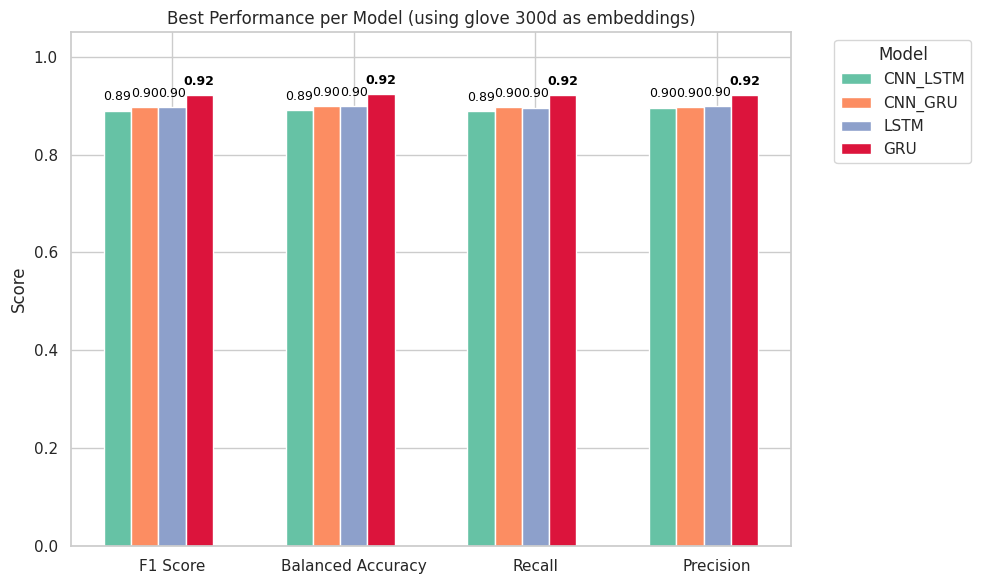

In [ ]:
summary_metrics = {
    "Model": [],
    "F1 Score": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": []
}

for model_name, metrics in model_metrics.items():
    summary_metrics["Model"].append(model_name)
    summary_metrics["F1 Score"].append(max(metrics["test_f1s"]))
    summary_metrics["Balanced Accuracy"].append(max(metrics["test_balanced_accs"]))
    summary_metrics["Recall"].append(max(metrics["test_recalls"]))
    summary_metrics["Precision"].append(max(metrics["test_precisions"]))

df_summary = pd.DataFrame(summary_metrics)
df_melted = df_summary.melt(id_vars="Model", var_name="Metric", value_name="Score")

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

models = df_summary["Model"].tolist()
palette = sns.color_palette("Set2", len(models))

# Plotting each metric group
for i, metric in enumerate(df_melted["Metric"].unique()):
    data = df_melted[df_melted["Metric"] == metric]
    max_score = data["Score"].max()

    for j, (index, row) in enumerate(data.iterrows()):
        color = "crimson" if row["Score"] == max_score else palette[models.index(row["Model"])]
        bar = ax.bar(
            x=i - 0.3 + j * (0.6 / len(models)),
            height=row["Score"],
            width=0.6 / len(models),
            color=color,
            label=row["Model"] if i == 0 else "",
        )
        ax.text(
            x=bar[0].get_x() + bar[0].get_width() / 2,
            y=row["Score"] + 0.015,
            s=f"{row['Score']:.2f}",
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            fontweight='bold' if row["Score"] == max_score else 'normal'
        )

ax.set_xticks(range(len(df_melted["Metric"].unique())))
ax.set_xticklabels(df_melted["Metric"].unique())
ax.set_ylim(0, 1.05)
ax.set_ylabel("Score")
ax.set_title("Best Performance per Model (using glove 300d as embeddings)")
ax.grid(True, axis='y')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("best_model_performance_comparison_all_values_glove300d.png")
plt.show()

---
Among the evaluated architectures, the GRU model achieved the best overall performance with an F1 score, balanced accuracy, recall, and precision all reaching 0.92. While the other models (CNN_LSTM, CNN_GRU, LSTM) also performed well, GRU demonstrated a consistent advantage across all metrics, indicating its strong suitability for the given text classification task using GloVe 300d embeddings.

---
#5. Analyzing the Distribution of Misclassifications

---

All these models outperform the others. Therefore, for the criticizing phase, we choose the GRU model.

In [ ]:
def plot_confusion_matrix(labels, pred_labels, num_classes = NUM_CLASSES):
    """Plots the confusion matrix with actual labels and predicted labels."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    cm_display.plot(values_format='d', cmap='Blues', ax=ax)
    plt.title('Confusion Matrix (using Glove 300d as embeddings)')
    plt.show()

def evaluate_and_analyze(model, test_loader, device, num_classes = NUM_CLASSES):
    """Evaluates and analyzes model performance on the test set."""
    model.eval()

    all_labels = []
    all_preds = []
    all_probs = []
    all_indices = []

    top_correct = []
    top_wrong = []

    with torch.no_grad():
        for idx, (inputs, labels, raw_text) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_indices.extend(range(len(labels)))

            correct_indices = (preds == labels).nonzero(as_tuple=True)[0]
            wrong_indices = (preds != labels).nonzero(as_tuple=True)[0]

            # Store correct predictions
            for correct_idx in correct_indices[:]:
                top_correct.append({
                    'index': correct_idx.item(),
                    'true_label': labels[correct_idx].item(),
                    'predicted_label': preds[correct_idx].item(),
                    'probability': probs[correct_idx, preds[correct_idx]].cpu().item(),
                    'text': raw_text[correct_idx.item()] if raw_text is not None else None
                })

            # Store wrong predictions
            for wrong_idx in wrong_indices[:]:
                top_wrong.append({
                    'index': wrong_idx.item(),
                    'true_label': labels[wrong_idx].item(),
                    'predicted_label': preds[wrong_idx].item(),
                    'probability': probs[wrong_idx, preds[wrong_idx]].cpu().item(),
                    'text': raw_text[wrong_idx.item()] if raw_text is not None else None
                })

    df_correct = pd.DataFrame(top_correct)
    df_wrong = pd.DataFrame(top_wrong)

    class_report = classification_report(all_labels, all_preds, output_dict=True)
    df_results = pd.DataFrame(class_report).transpose()
    plot_confusion_matrix(all_labels, all_preds, num_classes)

    return df_results, df_correct, df_wrong, all_labels, all_preds

def plot_wrong_distributions(wrong_indices, all_labels, all_preds, num_classes =  NUM_CLASSES):
    """Plots the distribution of wrong predictions for each class."""
    class_counts_wrong = defaultdict(int)

    for idx in wrong_indices:
        true_label = all_labels[idx]
        class_counts_wrong[true_label] += 1

    class_labels = sorted(class_counts_wrong.keys())
    counts = [class_counts_wrong[label] for label in class_labels]
    colors = sns.color_palette("husl", len(class_labels))

    class_names = [f"Class {label}" for label in class_labels]

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    plt.barh(class_names, counts, color=colors)
    plt.xlabel('Number of Wrong Predictions')
    plt.ylabel('Crop Disease Classes')
    plt.title('Distribution of Wrong Predictions for Each Class')

    for i, (count, name) in enumerate(zip(counts, class_names)):
        plt.text(count, i, str(count), ha='left', va='center')

    plt.show()

In [ ]:
model = GRU_Model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, hidden_dim=250, num_layers=1, dropout_prob=0.3, embedding_weights=embedding_matrix, freeze_embeddings=False).to(device)
model.load_state_dict(torch.load("/content/GRU_multi_class_loss_gap_accuracy_gap_5%_glove300d.pth"))

<All keys matched successfully>

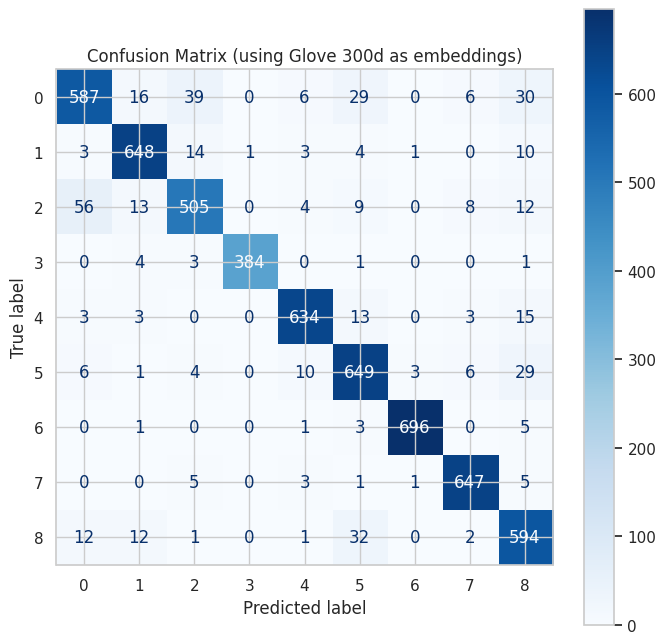

In [ ]:
df_results, df_correct, df_wrong, all_labels, all_preds= evaluate_and_analyze(model, test_loader, device)

---
Recall:

The different diseases and their corresponding labels in the dataset:

  0 : Tuberculosis \\
  1 : Cholera \\
  2 : Leprosy \\
  3 : Ebola \\
  4 : Leukemia \\
  5 : Asthma \\
  6 : Parkinson \\
  7 : Lupus \\
  8 : Cystic Fibrosis \\

---

---

---

In [ ]:
df_wrong.tail()

,index,true_label,predicted_label,probability,text
449,1,2,0,0.828948,introduction need shorten treatment duration t...
450,9,2,0,0.905660,background rifampicin resistance rr associated...
451,13,4,5,0.597663,covid 19 convalescent plasma ccp important the...
452,14,2,5,0.965969,background maculopapular drug eruption mpe rea...
453,3,2,0,0.830927,tuberculosis tb covid 19 become significant he...


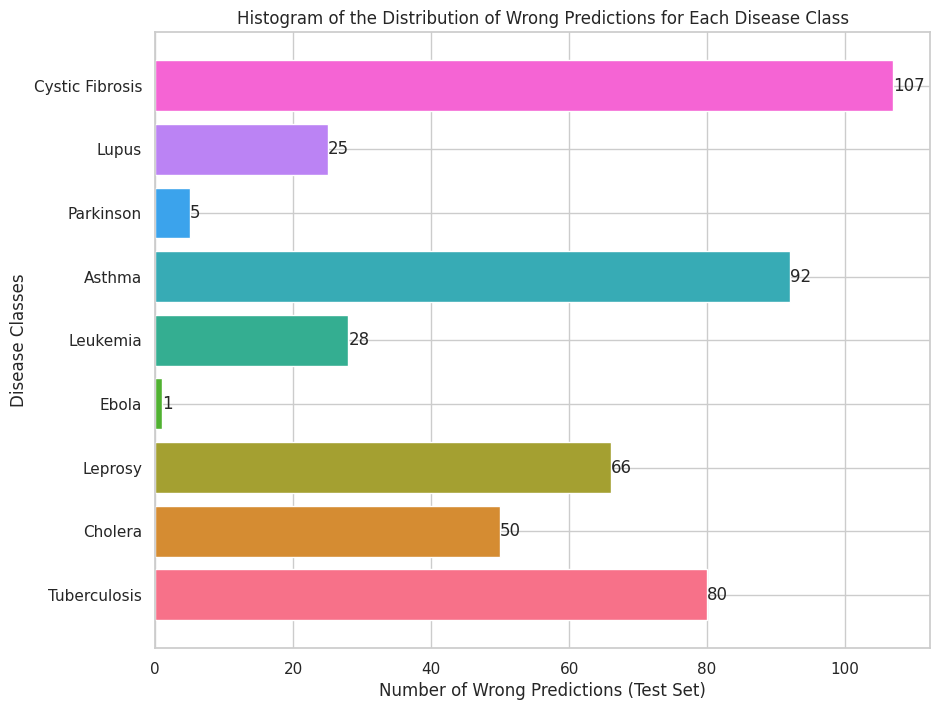

In [ ]:
wrong_df = pd.DataFrame({'predictions': all_preds, 'labels': all_labels})
wrong_df['wrong'] = wrong_df['predictions'] != wrong_df['labels']

wrong_class_counts = defaultdict(int)
for _, row in wrong_df.iterrows():
    if row['wrong']:
        wrong_class_counts[row['predictions']] += 1

wrong_class_labels = sorted(wrong_class_counts.keys())
wrong_counts = [wrong_class_counts[label] for label in wrong_class_labels]
wrong_colors = sns.color_palette("husl", len(wrong_class_labels))

class_names_dict = {
    0: 'Tuberculosis',
    1: 'Cholera',
    2: 'Leprosy',
    3: 'Ebola',
    4: 'Leukemia',
    5: 'Asthma',
    6: 'Parkinson',
    7: 'Lupus',
    8: 'Cystic Fibrosis'
}

class_names = [class_names_dict[label] for label in wrong_class_labels]

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
plt.barh(class_names, wrong_counts, color=wrong_colors)
plt.xlabel('Number of Wrong Predictions (Test Set)')
plt.ylabel('Disease Classes')
plt.title('Histogram of the Distribution of Wrong Predictions for Each Disease Class')

for i, (count, name) in enumerate(zip(wrong_counts, class_names)):
    plt.text(count, i, str(count), ha='left', va='center')
plt.show()

---

The model struggles most with distinguishing diseases such as Cystic Fibrosis, Asthma, and Tuberculosis, as indicated by their high number of misclassifications in the test set. Conversely, diseases like Ebola and Parkinson are predicted with high accuracy, suggesting more distinct representations or stronger learned patterns for those classes.